In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

def export(df: pd.DataFrame, path_no_dot: str, index=True):
    df.to_csv(f'exports/{path_no_dot}.csv', index=index)
    df.to_excel(f'exports/{path_no_dot}.xlsx', index=index)


# when 2023 singles is finishe, uncomment ###'s from this cell!

# data initialization
players = pd.read_csv('data/players.csv')
matches_2021_2s = pd.read_csv('data/matches_2021_2s.csv',na_values="None")
matches_2022_1s = pd.read_csv('data/matches_2022_1s.csv',na_values="None")
matches_2022_2s = pd.read_csv('data/matches_2022_2s.csv',na_values="None")
matches_2023_1s = pd.read_csv('data/matches_2023_1s.csv',na_values="None")
matches_2023_2s = pd.read_csv('data/matches_2023_2s.csv',na_values="None")

def apply_int(x):
    if np.isnan(x):
        return x
    else:
        return int(x)
    
# data cleaning
players.index.name = "Players"
players.player = players.player.apply(str.strip)
# casting to ints!
players.replace(to_replace="None", value=0, inplace=True)
players['seed_2021_2s'] = players['seed_2021_2s'].apply(apply_int)
players['seed_2022_1s'] = players['seed_2022_1s'].apply(apply_int)
players['seed_2022_2s'] = players['seed_2022_2s'].apply(apply_int)
players['seed_2023_1s'] = players['seed_2023_1s'].apply(apply_int)
players['seed_2023_2s'] = players['seed_2023_2s'].apply(apply_int)
players.replace(to_replace=0, value=None, inplace=True)

# map seeds to matches
map_2021_2s = pd.Series(players['seed_2021_2s'].values, index=players['player']).dropna().to_dict()
matches_2021_2s['seed1'] = matches_2021_2s.t1p1.map(map_2021_2s)
matches_2021_2s['seed2'] = matches_2021_2s.t2p1.map(map_2021_2s)
map_2022_1s = pd.Series(players['seed_2022_1s'].values, index=players['player']).dropna().to_dict()
matches_2022_1s['seed1'] = matches_2022_1s.p1.map(map_2022_1s)
matches_2022_1s['seed2'] = matches_2022_1s.p2.map(map_2022_1s)
map_2022_2s = pd.Series(players['seed_2022_2s'].values, index=players['player']).dropna().to_dict()
matches_2022_2s['seed1'] = matches_2022_2s.t1p1.map(map_2022_2s)
matches_2022_2s['seed2'] = matches_2022_2s.t2p1.map(map_2022_2s)
map_2023_1s = pd.Series(players['seed_2023_1s'].values, index=players['player']).dropna().to_dict()
matches_2023_1s['seed1'] = matches_2023_1s.p1.map(map_2023_1s)
matches_2023_1s['seed2'] = matches_2023_1s.p2.map(map_2023_1s)
map_2023_2s = pd.Series(players['seed_2023_2s'].values, index=players['player']).dropna().to_dict()
matches_2023_2s['seed1'] = matches_2023_2s.t1p1.map(map_2023_2s)
matches_2023_2s['seed2'] = matches_2023_2s.t2p1.map(map_2023_2s)
# create a cumulative singles matches table
matches_1s = pd.concat(
    [matches_2022_1s
    , matches_2023_1s]
    ).reset_index(drop=True)
matches_1s.index.name = "All Singles Matches"
# create a cumulative doubles matches table
matches_2s = pd.concat(
    [matches_2021_2s
    , matches_2022_2s
    , matches_2023_2s]
    ).reset_index(drop=True)
matches_2s.index.name = "All Doubles Matches"

# cleaning singles matches and doubles mataches
matches_1s.p1 = matches_1s.p1.apply(str.strip)
matches_1s.p2 = matches_1s.p2.apply(str.strip)
matches_1s.seed1 = matches_1s.seed1.apply(apply_int)
matches_1s.seed2 = matches_1s.seed2.apply(apply_int)
matches_2s.t1p1 = matches_2s.t1p1.apply(str.strip)
matches_2s.t1p2 = matches_2s.t1p2.apply(str.strip)
matches_2s.t2p1 = matches_2s.t2p1.apply(str.strip)
matches_2s.t2p2 = matches_2s.t2p2.apply(str.strip)
matches_2s.seed1 = matches_2s.seed1.apply(apply_int)
matches_2s.seed2 = matches_2s.seed2.apply(apply_int)

# per-match total possible cups
matches_1s['tpc'] = matches_1s.apply(lambda row: max(row.score1, row.score2), axis=1)
matches_2s['tpc'] = matches_2s.apply(lambda row: max(row.score1, row.score2), axis=1)

# number of events played in 
players['num_events'] = players.iloc[:,["seed" == x[0:4] for x in players.columns]].count(axis=1)

# finding seed z_scores for each player
players['z_seed_2021_2'] = (players.seed_2021_2s.astype(float) - players.seed_2021_2s.astype(float).mean()) / players.seed_2021_2s.astype(float).std()
players['z_seed_2022_1'] = (players.seed_2022_1s.astype(float) - players.seed_2022_1s.astype(float).mean()) / players.seed_2022_1s.astype(float).std()
players['z_seed_2022_2'] = (players.seed_2022_2s.astype(float) - players.seed_2022_2s.astype(float).mean()) / players.seed_2022_2s.astype(float).std()
players['z_seed_2023_1'] = (players.seed_2023_1s.astype(float) - players.seed_2023_1s.astype(float).mean()) / players.seed_2023_1s.astype(float).std()
players['z_seed_2023_2'] = (players.seed_2023_2s.astype(float) - players.seed_2023_2s.astype(float).mean()) / players.seed_2023_2s.astype(float).std()

# negatives means you're typically seeded better than average, positives means you're typically seeded worse than average
players['avg_norm_seed'] = np.nanmean(players.loc[:,['z' in x for x in players.columns]].astype(float), axis=1)

# cell outputs
display(players)
display(matches_1s)
display(matches_2s)

,player,grad_year,2019,2020,2021,2022,2023,seed_2021_2s,seed_2022_1s,seed_2022_2s,seed_2023_1s,beach_week_2023,seed_2023_2s,num_events,z_seed_2021_2,z_seed_2022_1,z_seed_2022_2,z_seed_2023_1,z_seed_2023_2,avg_norm_seed
Players,,,,,,,,,,,,,,,,,,,,
0,Kristian Banlaoi,2022,cymbals,cymbals,cymbals,NaN,NaN,NaN,1.0,NaN,NaN,False,NaN,1,NaN,-1.565248,NaN,NaN,NaN,-1.565248
1,Kevin Cooper,2023,cymbals,cymbals,bass,bass,NaN,2.0,2.0,2.0,NaN,False,NaN,3,-1.056443,-1.341641,-1.129159,NaN,NaN,-1.175748
2,Rohan Chowla,2025,NaN,NaN,snare,snare,snare,3.0,3.0,1.0,2.0,True,1.0,5,-0.633866,-1.118034,-1.505545,-1.421637,-1.479020,-1.231620
3,Rose Roché,2023,pit-cymbals,pit-cymbals,pit-cymbals,pit-cymbals,NaN,1.0,4.0,3.0,NaN,True,NaN,3,-1.479020,-0.894427,-0.752773,NaN,NaN,-1.042073
4,Aaron Carter,2023,tenors,tenors,tenors,tenors,NaN,1.0,5.0,3.0,8.0,True,NaN,4,-1.479020,-0.670820,-0.752773,-0.355409,NaN,-0.814506
5,Roman Ramirez,2023,bass,bass,bass,bass,NaN,2.0,6.0,2.0,1.0,True,NaN,4,-1.056443,-0.447214,-1.129159,-1.599342,NaN,-1.058039
6,Coby Lovelace,2023,snare,snare,snare,snare,NaN,4.0,7.0,6.0,9.0,True,NaN,4,-0.211289,-0.223607,0.376386,-0.177705,NaN,-0.059053
7,Paul Bartenfeld,2023,snare,snare,snare,snare,NaN,6.0,8.0,9.0,19.0,True,NaN,4,0.633866,0.000000,1.505545,1.599342,NaN,0.934688
8,Jason Jackson,2024,NaN,NaN,cymbals,cymbals,NaN,4.0,9.0,4.0,7.0,False,3.0,5,-0.211289,0.223607,-0.376386,-0.533114,-0.633866,-0.306210


,event,match_number,fe1,fe2,p1,p2,score1,score2,seed1,seed2,tpc
All Singles Matches,,,,,,,,,,,
0,2022_1s,1,False,False,Paul Bartenfeld,Jason Jackson,4,6,8,9,6
1,2022_1s,2,False,False,Rose Roché,Gabe Silverstein,5,6,4,13,6
2,2022_1s,3,False,False,Aaron Carter,Leah Baetcke,2,6,5,12,6
3,2022_1s,4,False,False,Kevin Cooper,Carla Betancourt,5,6,2,15,6
4,2022_1s,5,False,False,Coby Lovelace,Jack Massingill,5,6,7,10,6
...,...,...,...,...,...,...,...,...,...,...,...
61,2023_1s,33,True,True,Rohan Chowla,Aaron Carter,1,6,2,8,6
62,2023_1s,34,False,False,Nathan Snow,Kevin Lee,4,6,12,3,6
63,2023_1s,35,True,True,Nathan Snow,Aaron Carter,7,9,12,8,9


,event,match_number,fe1,fe2,t1p1,t1p2,t2p1,t2p2,score1,score2,seed1,seed2,tpc
All Doubles Matches,,,,,,,,,,,,,
0,2021_2s,1,False,False,Rose Roché,Aaron Carter,Brian Tafazoli,Evan Sooklal,6,3,1,8,6
1,2021_2s,2,False,False,Coby Lovelace,Jason Jackson,Jack Massingill,Will Simpson,6,3,4,5,6
2,2021_2s,3,False,False,Kevin Cooper,Roman Ramirez,Ann Hall,Anna Brown,6,3,2,7,6
3,2021_2s,4,False,False,Rohan Chowla,Kevin Lee,Paul Bartenfeld,Leah Baetcke,6,0,3,6,6
4,2021_2s,5,True,True,Brian Tafazoli,Evan Sooklal,Jack Massingill,Will Simpson,4,6,8,5,6
5,2021_2s,6,True,True,Ann Hall,Anna Brown,Paul Bartenfeld,Leah Baetcke,6,4,7,6,6
6,2021_2s,7,False,False,Rose Roché,Aaron Carter,Coby Lovelace,Jason Jackson,5,6,1,4,6
7,2021_2s,8,False,False,Kevin Cooper,Roman Ramirez,Rohan Chowla,Kevin Lee,5,6,2,3,6
8,2021_2s,9,True,True,Kevin Cooper,Roman Ramirez,Ann Hall,Anna Brown,6,5,2,7,6


In [2]:
# # CUPS TABLE

# # initalization with every player
# cups_table = pd.DataFrame()
# cups_table['player'] = players.player
# cups_table.index.name = "Cups Table"

# # number of games played in singles
# list_games_played_1s = list()
# for name in players.player:
#     games_played_1s = 0
#     for i in range(len(matches_1s)):
#         if any([name == matches_1s.loc[i, x] for x in ["p1", "p2"]]):
#             games_played_1s += 1
#     list_games_played_1s.append(games_played_1s)
# cups_table['GP_1s'] = list_games_played_1s

# # number of games played in doubles
# list_games_played_2s = list()
# for name in players.player:
#     games_played_2s = 0
#     for i in range(len(matches_2s)):
#         if any([name == matches_2s.loc[i, x] for x in ["t1p1", "t1p2", "t2p1", "t2p2"]]):
#             games_played_2s += 1
#     list_games_played_2s.append(games_played_2s)
# cups_table['GP_2s'] = list_games_played_2s

# # per-match total possible cups
# matches_1s['tpc'] = matches_1s.apply(lambda row: max(row.score1, row.score2), axis=1)
# matches_2s['tpc'] = matches_2s.apply(lambda row: max(row.score1, row.score2), axis=1)

# # total number of cups scored in singles
# list_CS_1s = list()
# for name in players.player:
#     CS_1s = 0
#     for i in range(len(matches_1s)):
#         if name == matches_1s.loc[i, "p1"]:
#             CS_1s += matches_1s.loc[i, 'score1']
#         if name == matches_1s.loc[i, "p2"]:
#             CS_1s += matches_1s.loc[i, 'score2']
#     list_CS_1s.append(CS_1s)
# cups_table['CS_1s'] = list_CS_1s

# # total number of cups available in singles
# list_CA_1s = list()
# for name in players.player:
#     CA_1s = 0
#     for i in range(len(matches_1s)):
#         if any([name == matches_1s.loc[i, x] for x in ["p1", "p2"]]):
#             CA_1s += matches_1s.loc[i, 'tpc']
#     list_CA_1s.append(CA_1s)
# cups_table['CA_1s'] = list_CA_1s

# # total number of cups scored in doubles (weighted by 0.5)
# list_CS_2s = list()
# for name in players.player:
#     CS_2s = 0
#     for i in range(len(matches_2s)):
#         if any([name == matches_2s.loc[i, x] for x in ["t1p1", "t1p2"]]):
#             CS_2s += matches_2s.loc[i, 'score1'] / 2
#         if any([name == matches_2s.loc[i, x] for x in ["t2p1", "t2p2"]]):
#             CS_2s += matches_2s.loc[i, 'score2'] / 2
#     list_CS_2s.append(CS_2s)
# cups_table['CS_2s'] = list_CS_2s

# # total number of cups availabe in doubles
# list_CA_2s = list()
# for name in players.player:
#     CA_2s = 0
#     for i in range(len(matches_2s)):
#         if any([name == matches_2s.loc[i, x] for x in ["t1p1", "t1p2", "t2p1", "t2p2"]]):
#             CA_2s += matches_2s.loc[i, 'tpc'] / 2
#     list_CA_2s.append(CA_2s)
# cups_table['CA_2s'] = list_CA_2s

# # cups scored per game in singles
# cups_table['CS/GP_1s'] = cups_table.CS_1s / cups_table.GP_1s

# # cups scored per game in doubles (weighted by 0.5)
# cups_table['CS/GP_2s'] = cups_table.CS_2s / cups_table.GP_2s


# # per-player percent cups hit, both singles and doubles (weighted by 0.5)
# # THIS IS THE METRIC TO DETERMINE PAST PERFORMANCE, AND POTENTIAL SEEDING, favors efficiency regardless of participation
# cups_table['PCT_CS'] = cups_table.apply(lambda row: (row.CS_1s + row.CS_2s) / (row.CA_1s + row.CA_2s) * 100, axis=1)
# # cups_table['rank_PCT_CS'] = cups_table.PCT_CS.rank(ascending=False).apply(int)

# display(cups_table.sort_values('PCT_CS', ascending=False).reset_index(drop=True))

In [3]:

## FA DIFFERENTIAL TABLE

fa_table = pd.DataFrame()
fa_table['player'] = players.player
fa_table.index.name = "Cup Points Table"

# number of games played in singles
list_games_played_1s = list()
for name in players.player:
    games_played_1s = 0
    for i in range(len(matches_1s)):
        if any([name == matches_1s.loc[i, x] for x in ["p1", "p2"]]):
            games_played_1s += 1
    list_games_played_1s.append(games_played_1s)
fa_table['GP_1s'] = list_games_played_1s


# pf_1s: 'points for' player
# pa_1s: 'points against' player
# +/-_1s: 'net differential' player
list_pf_1s = list()
list_pa_1s = list()
for name in players.player:
    pf_1s = 0
    pa_1s = 0
    for i in range(len(matches_1s)):
        if name == matches_1s.loc[i, "p1"]:
            pf_1s += matches_1s.loc[i, "score1"]
            pa_1s += matches_1s.loc[i, "score2"]
        if name == matches_1s.loc[i, "p2"]:
            pf_1s += matches_1s.loc[i, "score2"]
            pa_1s += matches_1s.loc[i, "score1"]
            
    list_pf_1s.append(pf_1s)
    list_pa_1s.append(pa_1s)

fa_table['PF_1s'] = list_pf_1s
fa_table['PA_1s'] = list_pa_1s

# total number of cups available in singles
list_CA_1s = list()
for name in players.player:
    CA_1s = 0
    for i in range(len(matches_1s)):
        if any([name == matches_1s.loc[i, x] for x in ["p1", "p2"]]):
            CA_1s += matches_1s.loc[i, 'tpc']
    list_CA_1s.append(CA_1s)
fa_table['CA_1s'] = list_CA_1s

fa_table['+/-_1s'] = fa_table['PF_1s'] - fa_table['PA_1s']

# score differential in doubles (weighted by 0.5 or weighted by 1.0) idk!


# number of games played in doubles
list_games_played_2s = list()
for name in players.player:
    games_played_2s = 0
    for i in range(len(matches_2s)):
        if any([name == matches_2s.loc[i, x] for x in ["t1p1", "t1p2", "t2p1", "t2p2"]]):
            games_played_2s += 1
    list_games_played_2s.append(games_played_2s)
fa_table['GP_2s'] = list_games_played_2s

# pf_2s: 'points for' player
# pa_2s: 'points against' player
# +/-_2s: 'net differential' player
list_pf_2s = list()
list_pa_2s = list()
for name in players.player:
    pf_2s = 0
    pa_2s = 0
    for i in range(len(matches_2s)):
        if any([name == matches_2s.loc[i, x] for x in ["t1p1", "t1p2"]]):
            pf_2s += matches_2s.loc[i, "score1"] # * 0.5
            pa_2s += matches_2s.loc[i, "score2"] # * 0.5
        if any([name == matches_2s.loc[i, x] for x in ["t2p1", "t2p2"]]):
            pf_2s += matches_2s.loc[i, "score2"] # * 0.5
            pa_2s += matches_2s.loc[i, "score1"] # * 0.5
            
    list_pf_2s.append(pf_2s)
    list_pa_2s.append(pa_2s)

weight = 1

fa_table['PF_2s'] = [x * weight for x in list_pf_2s]
fa_table['PA_2s'] = [x * weight for x in list_pa_2s]

# total number of cups availabe in doubles
list_CA_2s = list()
for name in players.player:
    CA_2s = 0
    for i in range(len(matches_2s)):
        if any([name == matches_2s.loc[i, x] for x in ["t1p1", "t1p2", "t2p1", "t2p2"]]):
            CA_2s += matches_2s.loc[i, 'tpc'] # / 2
    list_CA_2s.append(CA_2s)
fa_table['CA_2s'] = list_CA_2s

fa_table['+/-_2s'] = fa_table['PF_2s'] - fa_table['PA_2s']

# cummulative
fa_table['GP'] = fa_table.GP_1s + fa_table.GP_2s
fa_table['PF'] = fa_table.PF_1s + fa_table.PF_2s
fa_table['PA'] = fa_table.PA_1s + fa_table.PA_2s
fa_table['CA'] = fa_table.CA_1s + fa_table.CA_2s
fa_table['+/-'] = fa_table.PF - fa_table.PA

# per game
fa_table['PF/G'] = fa_table['PF'] / fa_table['GP']
fa_table['PA/G'] = fa_table['PA'] / fa_table['GP']
fa_table['CA/G'] = fa_table['CA'] / fa_table['GP']
fa_table['+/-/G'] = fa_table['+/-'] / fa_table['GP']

# dominance
fa_table['PF/PA'] = fa_table.apply(lambda row: (row.PF_1s + row.PF_2s) / (row.PA_1s + row.PA_2s) * 100, axis=1)
# efficiency v1
fa_table['PF/CA'] = fa_table.apply(lambda row: (row.PF_1s + row.PF_2s) / (row.CA_1s + row.CA_2s) * 100, axis=1)
# efficiency
fa_table['(+/-)/CA'] = fa_table.apply(lambda row: ((row.PF_1s + row.PF_2s) - (row.PA_1s + row.PA_2s)) / (row.CA_1s + row.CA_2s), axis=1)

with pd.option_context('display.max_rows', 100, 'display.max_columns', None):
    display(fa_table.sort_values('(+/-)/CA', ascending=False).reset_index(drop=True))

,player,GP_1s,PF_1s,PA_1s,CA_1s,+/-_1s,GP_2s,PF_2s,PA_2s,CA_2s,+/-_2s,GP,PF,PA,CA,+/-,PF/G,PA/G,CA/G,+/-/G,PF/PA,PF/CA,(+/-)/CA
0,Kevin Lee,6,31,26,36,5,15,95,70,99,25,21,126,96,135,30,6.000000,4.571429,6.428571,1.428571,131.250000,93.333333,0.222222
1,Roman Ramirez,11,71,54,75,17,10,53,49,60,4,21,124,103,135,21,5.904762,4.904762,6.428571,1.000000,120.388350,91.851852,0.155556
2,Rohan Chowla,11,66,70,81,-4,15,95,70,99,25,26,161,140,180,21,6.192308,5.384615,6.923077,0.807692,115.000000,89.444444,0.116667
3,Aaron Carter,11,65,52,72,13,7,38,38,45,0,18,103,90,117,13,5.722222,5.000000,6.500000,0.722222,114.444444,88.034188,0.111111
4,Eric LastName,0,0,0,0,0,5,31,28,33,3,5,31,28,33,3,6.200000,5.600000,6.600000,0.600000,110.714286,93.939394,0.090909
5,Kevin Cooper,5,26,22,30,4,10,53,49,60,4,15,79,71,90,8,5.266667,4.733333,6.000000,0.533333,111.267606,87.777778,0.088889
6,Nathan Snow,5,29,27,33,2,5,31,28,33,3,10,60,55,66,5,6.000000,5.500000,6.600000,0.500000,109.090909,90.909091,0.075758
7,Kristian Banlaoi,3,16,15,18,1,0,0,0,0,0,3,16,15,18,1,5.333333,5.000000,6.000000,0.333333,106.666667,88.888889,0.055556
8,Julie Jackson,0,0,0,0,0,3,15,14,18,1,3,15,14,18,1,5.000000,4.666667,6.000000,0.333333,107.142857,83.333333,0.055556
9,Carolyn LastName,0,0,0,0,0,3,15,14,18,1,3,15,14,18,1,5.000000,4.666667,6.000000,0.333333,107.142857,83.333333,0.055556


In [4]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', None):
    display(fa_table)

,player,GP_1s,PF_1s,PA_1s,CA_1s,+/-_1s,GP_2s,PF_2s,PA_2s,CA_2s,+/-_2s,GP,PF,PA,CA,+/-,PF/G,PA/G,CA/G,+/-/G,PF/PA,PF/CA,(+/-)/CA
Cup Points Table,,,,,,,,,,,,,,,,,,,,,,,
0,Kristian Banlaoi,3,16,15,18,1,0,0,0,0,0,3,16,15,18,1,5.333333,5.000000,6.000000,0.333333,106.666667,88.888889,0.055556
1,Kevin Cooper,5,26,22,30,4,10,53,49,60,4,15,79,71,90,8,5.266667,4.733333,6.000000,0.533333,111.267606,87.777778,0.088889
2,Rohan Chowla,11,66,70,81,-4,15,95,70,99,25,26,161,140,180,21,6.192308,5.384615,6.923077,0.807692,115.000000,89.444444,0.116667
3,Rose Roché,2,8,12,12,-4,7,38,38,45,0,9,46,50,57,-4,5.111111,5.555556,6.333333,-0.444444,92.000000,80.701754,-0.070175
4,Aaron Carter,11,65,52,72,13,7,38,38,45,0,18,103,90,117,13,5.722222,5.000000,6.500000,0.722222,114.444444,88.034188,0.111111
5,Roman Ramirez,11,71,54,75,17,10,53,49,60,4,21,124,103,135,21,5.904762,4.904762,6.428571,1.000000,120.388350,91.851852,0.155556
6,Coby Lovelace,6,34,35,39,-1,8,48,44,54,4,14,82,79,93,3,5.857143,5.642857,6.642857,0.214286,103.797468,88.172043,0.032258
7,Paul Bartenfeld,4,15,24,24,-9,4,13,24,24,-11,8,28,48,48,-20,3.500000,6.000000,6.000000,-2.500000,58.333333,58.333333,-0.416667
8,Jason Jackson,5,27,31,33,-4,12,76,73,84,3,17,103,104,117,-1,6.058824,6.117647,6.882353,-0.058824,99.038462,88.034188,-0.008547


In [5]:
# WIN-LOSS TABLE: favors winners and those with greater participation
# W = UW + EW
# L = UL + EL
# RL = URL + ERL

wl_table = pd.DataFrame()
wl_table['player'] = players.player
wl_table.index.name = "All Records Table"

# wins in singles
list_W_1s = list()
list_UW_1s = list()
list_EW_1s = list()
for name in players.player:
    W_1s = 0
    UW_1s = 0
    EW_1s = 0
    for i in range(len(matches_1s)):
        if name == matches_1s.loc[i, "p1"]:
            if matches_1s.loc[i, "score1"] > matches_1s.loc[i, "score2"]:
                W_1s += 1
                if matches_1s.loc[i, 'fe1']:
                    EW_1s += 1
                else:
                    UW_1s += 1
        if name == matches_1s.loc[i, "p2"]:
            if matches_1s.loc[i, "score1"] < matches_1s.loc[i, "score2"]:
                W_1s += 1
                if matches_1s.loc[i, 'fe2']:
                    EW_1s += 1
                else:
                    UW_1s += 1
    list_W_1s.append(W_1s)
    list_UW_1s.append(UW_1s)
    list_EW_1s.append(EW_1s)
wl_table['W_1s'] = list_W_1s
wl_table['UW_1s'] = list_UW_1s
wl_table['EW_1s'] = list_EW_1s

# regular-time losses in singles
list_L_1s = list()
list_UL_1s = list()
list_EL_1s = list()
for name in players.player:
    L_1s = 0
    UL_1s = 0
    EL_1s = 0
    for i in range(len(matches_1s)):
        if matches_1s.loc[i, "tpc"] == 6:
            if name == matches_1s.loc[i, "p1"]:
                if matches_1s.loc[i, "score1"] < matches_1s.loc[i, "score2"]:
                    L_1s += 1
                    if matches_1s.loc[i, 'fe1']:
                        EL_1s += 1
                    else:
                        UL_1s += 1
            if name == matches_1s.loc[i, "p2"]:
                if matches_1s.loc[i, "score1"] > matches_1s.loc[i, "score2"]:
                    L_1s += 1
                    if matches_1s.loc[i, 'fe2']:
                        EL_1s += 1
                    else:
                        UL_1s += 1
    list_L_1s.append(L_1s)
    list_UL_1s.append(UL_1s)
    list_EL_1s.append(EL_1s)
wl_table['L_1s'] = list_L_1s
wl_table['UL_1s'] = list_UL_1s
wl_table['EL_1s'] = list_EL_1s

# overtime losses in singles
list_RL_1s = list()
list_URL_1s = list()
list_ERL_1s = list()
for name in players.player:
    RL_1s = 0
    URL_1s = 0
    ERL_1s = 0
    for i in range(len(matches_1s)):
        if matches_1s.loc[i, "tpc"] > 6:
            if name == matches_1s.loc[i, "p1"]:
                if matches_1s.loc[i, "score1"] < matches_1s.loc[i, "score2"]:
                    RL_1s += 1
                    if matches_1s.loc[i, 'fe1']:
                        ERL_1s += 1
                    else:
                        URL_1s += 1
            if name == matches_1s.loc[i, "p2"]:
                if matches_1s.loc[i, "score1"] > matches_1s.loc[i, "score2"]:
                    RL_1s += 1
                    if matches_1s.loc[i, 'fe2']:
                        ERL_1s += 1
                    else:
                        URL_1s += 1
    list_RL_1s.append(RL_1s)
    list_URL_1s.append(URL_1s)
    list_ERL_1s.append(ERL_1s)
wl_table['RL_1s'] = list_RL_1s
wl_table['URL_1s'] = list_URL_1s
wl_table['ERL_1s'] = list_ERL_1s

# wins in doubles
list_W_2s = list()
list_UW_2s = list()
list_EW_2s = list()
for name in players.player:
    W_2s = 0
    UW_2s = 0
    EW_2s = 0
    for i in range(len(matches_2s)):
        if any([name == matches_2s.loc[i, x] for x in ["t1p1", "t1p2"]]):
            if matches_2s.loc[i, "score1"] > matches_2s.loc[i, "score2"]:
                W_2s += 1
                if matches_2s.loc[i, 'fe1']:
                    EW_2s += 1
                else:
                    UW_2s += 1
        if any([name == matches_2s.loc[i, x] for x in ["t2p1", "t2p2"]]):
            if matches_2s.loc[i, "score1"] < matches_2s.loc[i, "score2"]:
                W_2s += 1
                if matches_2s.loc[i, 'fe2']:
                    EW_2s += 1
                else:
                    UW_2s += 1
    list_W_2s.append(W_2s)
    list_UW_2s.append(UW_2s)
    list_EW_2s.append(EW_2s)
wl_table['W_2s'] = list_W_2s
wl_table['UW_2s'] = list_UW_2s
wl_table['EW_2s'] = list_EW_2s

# regular-time losses in doubles
list_L_2s = list()
list_UL_2s = list()
list_EL_2s = list()
for name in players.player:
    L_2s = 0
    UL_2s = 0
    EL_2s = 0
    for i in range(len(matches_2s)):
        if any([name == matches_2s.loc[i, x] for x in ["t1p1", "t1p2"]]):
            if (matches_2s.loc[i, "score1"] < matches_2s.loc[i, "score2"]) and (matches_2s.loc[i, "score2"] == 6):
                L_2s += 1
                if matches_2s.loc[i, 'fe1']:
                    EL_2s += 1
                else:
                    UL_2s += 1
        if any([name == matches_2s.loc[i, x] for x in ["t2p1", "t2p2"]]):
            if (matches_2s.loc[i, "score1"] > matches_2s.loc[i, "score2"]) and (matches_2s.loc[i, "score1"] == 6):
                L_2s += 1
                if matches_2s.loc[i, 'fe2']:
                    EL_2s += 1
                else:
                    UL_2s += 1
    list_L_2s.append(L_2s)
    list_UL_2s.append(UL_2s)
    list_EL_2s.append(EL_2s)
wl_table['L_2s'] = list_L_2s
wl_table['UL_2s'] = list_UL_2s
wl_table['EL_2s'] = list_EL_2s

# overtime losses in doubles
list_RL_2s = list()
list_URL_2s = list()
list_ERL_2s = list()
for name in players.player:
    RL_2s = 0
    URL_2s = 0
    ERL_2s = 0
    for i in range(len(matches_2s)):
        if any([name == matches_2s.loc[i, x] for x in ["t1p1", "t1p2"]]):
            if (matches_2s.loc[i, "score1"] < matches_2s.loc[i, "score2"]) and (matches_2s.loc[i, "score2"] > 6):
                RL_2s += 1
                if matches_2s.loc[i, 'fe1']:
                    ERL_2s += 1
                else:
                    URL_2s += 1
        if any([name == matches_2s.loc[i, x] for x in ["t2p1", "t2p2"]]):
            if (matches_2s.loc[i, "score1"] > matches_2s.loc[i, "score2"]) and (matches_2s.loc[i, "score1"] > 6):
                RL_2s += 1
                if matches_2s.loc[i, 'fe2']:
                    ERL_2s += 1
                else:
                    URL_2s += 1
    list_RL_2s.append(RL_2s)
    list_URL_2s.append(URL_2s)
    list_ERL_2s.append(ERL_2s)
wl_table['RL_2s'] = list_RL_2s
wl_table['URL_2s'] = list_URL_2s
wl_table['ERL_2s'] = list_ERL_2s

wl_table['UW'] = wl_table.UW_1s + wl_table.UW_2s
wl_table['EW'] = wl_table.EW_1s + wl_table.EW_2s
wl_table['UL'] = wl_table.UL_1s + wl_table.UL_2s
wl_table['EL'] = wl_table.EL_1s + wl_table.EL_2s
wl_table['URL'] = wl_table.URL_1s + wl_table.URL_2s
wl_table['ERL'] = wl_table.ERL_1s + wl_table.ERL_2s

wl_table['GP'] = fa_table.GP_1s + fa_table.GP_2s
wl_table['UGP'] = wl_table.UW + wl_table.UL + wl_table.URL
wl_table['EGP'] = wl_table.EW + wl_table.EL + wl_table.ERL


# win-loss as overdogs
# overdog win, underdog win, overdog loss, underdog loss
list_ODW = list()
list_UDW = list()
list_ODL = list()
list_UDL = list()
list_ODRL = list()
list_UDRL = list()

for name in players.player:

    ODW = 0
    UDW = 0
    ODL = 0
    UDL = 0
    ODRL = 0
    UDRL = 0

    for (i, row) in matches_1s.iterrows():
        if any([name == x for x in [row.p1]]):
            if row.seed1 < row.seed2:
                if row.score1 > row.score2:
                    ODW += 1
                elif row.score1 < row.score2:
                    if row.tpc > 6:
                        ODRL += 1
                    elif row.tpc == 6:
                        ODL += 1
                    else:
                        raise Exception("calculation error: tpc < 6")
                else:
                    raise Exception("calculation error: tie score!")
            elif row.seed1 > row.seed2:
                if row.score1 > row.score2:
                    UDW += 1
                elif row.score1 < row.score2:
                    if row.tpc > 6:
                        UDRL += 1
                    elif row.tpc == 6:
                        UDL += 1
                    else:
                        raise Exception("calculation error: tpc < 6")
                else:
                    raise Exception("calculation error: tie score!")
            else:
                raise Exception("calculation error: tie seed!")
        
        # I'm on team 2
        elif any([name == x for x in [row.p2]]):
            # I have a higher/worse seed
            if row.seed1 < row.seed2:
                # I lost
                if row.score1 > row.score2:
                    if row.tpc > 6:
                        UDRL += 1
                    elif row.tpc == 6:
                        UDL += 1
                    else:
                        raise Exception("calculation error: tpc < 6")
                elif row.score1 < row.score2:
                    UDW += 1
                else:
                    raise Exception("calculation error: tie score!")
            elif row.seed1 > row.seed2:
                if row.score1 > row.score2:
                    if row.tpc > 6:
                        ODRL += 1
                    elif row.tpc == 6:
                        ODL += 1
                    else:
                        raise Exception("calculation error: tpc < 6")
                elif row.score1 < row.score2:
                    ODW += 1
                else:
                    raise Exception("calculation error: tie score!")
            else:
                print(row.seed1)
                raise Exception("calculation error: tie seed!")

    for (i, row) in matches_2s.iterrows():
        if any([name == x for x in [row.t1p1, row.t1p2]]):
            if row.seed1 < row.seed2:
                if row.score1 > row.score2:
                    ODW += 1
                elif row.score1 < row.score2:
                    if row.tpc > 6:
                        ODRL += 1
                    elif row.tpc == 6:
                        ODL += 1
                    else:
                        raise Exception("calculation error: tpc < 6")
                else:
                    raise Exception("calculation error: tie score!")
            elif row.seed1 > row.seed2:
                if row.score1 > row.score2:
                    UDW += 1
                elif row.score1 < row.score2:
                    if row.tpc > 6:
                        UDRL += 1
                    elif row.tpc == 6:
                        UDL += 1
                    else:
                        raise Exception("calculation error: tpc < 6")
                else:
                    raise Exception("calculation error: tie score!")
            else:
                raise Exception("calculation error: tie seed!")
        
        # I'm on team 2
        elif any([name == x for x in [row.t2p1, row.t2p2]]):
            # I have a higher/worse seed
            if row.seed1 < row.seed2:
                # I lost
                if row.score1 > row.score2:
                    if row.tpc > 6:
                        UDRL += 1
                    elif row.tpc == 6:
                        UDL += 1
                    else:
                        raise Exception("calculation error: tpc < 6")
                elif row.score1 < row.score2:
                    UDW += 1
                else:
                    raise Exception("calculation error: tie score!")
            elif row.seed1 > row.seed2:
                if row.score1 > row.score2:
                    if row.tpc > 6:
                        ODRL += 1
                    elif row.tpc == 6:
                        ODL += 1
                    else:
                        raise Exception("calculation error: tpc < 6")
                elif row.score1 < row.score2:
                    ODW += 1
                else:
                    raise Exception("calculation error: tie score!")
            else:
                print(row.seed1)
                raise Exception("calculation error: tie seed!")
  
    list_ODW.append(ODW)
    list_UDW.append(UDW)
    list_ODL.append(ODL)
    list_UDL.append(UDL)
    list_ODRL.append(ODRL)
    list_UDRL.append(UDRL)

wl_table['ODW'] = list_ODW
wl_table['ODL'] = list_ODL
wl_table['ODRL'] = list_ODRL
wl_table['UDW'] = list_UDW
wl_table['UDL'] = list_UDL
wl_table['UDRL'] = list_UDRL

# total wins (2 points)
wl_table['W'] = wl_table.W_1s + wl_table.W_2s

# total losses (0 points)
wl_table['L'] = wl_table.L_1s + wl_table.L_2s

# total overtime lossess (1 point)
wl_table['RL'] = wl_table.RL_1s + wl_table.RL_2s

# total points
wl_table['PTS'] = (wl_table.UW * 2) + (wl_table.EW * 1) + (wl_table.L * 0) + (wl_table.RL * 1)
wl_table['PTS/EV'] = wl_table.PTS / players.num_events

# win percentages
wl_table['W_PCT'] = (wl_table.W) / (wl_table.GP) * 100
wl_table['UW_PCT'] = (wl_table.UW) / (wl_table.UGP) * 100
wl_table['EW_PCT'] = (wl_table.EW) / (wl_table.EGP) * 100

# cell outputs
with pd.option_context('display.max_rows', 100, 'display.max_columns', None):
    display(wl_table.sort_values('PTS', ascending=False).reset_index(drop=True))

,player,W_1s,UW_1s,EW_1s,L_1s,UL_1s,EL_1s,RL_1s,URL_1s,ERL_1s,W_2s,UW_2s,EW_2s,L_2s,UL_2s,EL_2s,RL_2s,URL_2s,ERL_2s,UW,EW,UL,EL,URL,ERL,GP,UGP,EGP,ODW,ODL,ODRL,UDW,UDL,UDRL,W,L,RL,PTS,PTS/EV,W_PCT,UW_PCT,EW_PCT
0,Rohan Chowla,7,6,1,3,1,2,1,0,1,12,8,4,3,2,1,0,0,0,14,5,3,3,0,1,26,17,9,17,6,1,2,0,0,19,6,1,34,6.800000,73.076923,82.352941,55.555556
1,Kevin Lee,4,4,0,2,1,1,0,0,0,12,8,4,3,2,1,0,0,0,12,4,3,2,0,0,21,15,6,13,5,0,3,0,0,16,5,0,28,7.000000,76.190476,80.000000,66.666667
2,Roman Ramirez,8,2,6,2,1,1,1,1,0,7,4,3,3,2,1,0,0,0,6,9,3,2,1,0,21,10,11,10,4,0,5,1,1,15,5,1,22,5.500000,71.428571,60.000000,81.818182
3,Jason Jackson,1,1,0,3,2,1,1,0,1,7,4,3,4,2,2,1,0,1,5,3,4,3,0,2,17,9,8,5,4,1,3,3,1,8,7,2,15,3.000000,47.058824,55.555556,37.500000
4,Aaron Carter,8,2,6,3,2,1,0,0,0,3,1,2,4,2,2,0,0,0,3,8,4,3,0,0,18,7,11,7,7,0,4,0,0,11,7,0,14,3.500000,61.111111,42.857143,72.727273
5,Kevin Cooper,3,0,3,2,1,1,0,0,0,7,4,3,3,2,1,0,0,0,4,6,3,2,0,0,15,7,8,8,4,0,2,1,0,10,5,0,14,4.666667,66.666667,57.142857,75.000000
6,Coby Lovelace,2,0,2,3,1,2,1,1,0,5,4,1,2,1,1,1,0,1,4,3,2,3,1,1,14,7,7,2,2,0,5,3,2,7,5,2,13,3.250000,50.000000,57.142857,42.857143
7,Cason Duszak,2,2,0,2,1,1,0,0,0,4,2,2,3,2,1,1,0,1,4,2,3,2,0,1,12,7,5,4,3,0,2,2,1,6,5,1,11,3.666667,50.000000,57.142857,40.000000
8,Nathan Snow,3,3,0,1,1,0,1,0,1,3,1,2,2,1,1,0,0,0,4,2,2,1,0,1,10,6,4,4,0,0,2,3,1,6,3,1,11,5.500000,60.000000,66.666667,50.000000
9,Leah Baetcke,4,4,0,3,1,2,1,1,0,0,0,0,3,2,1,1,0,1,4,0,3,3,1,1,12,8,4,2,1,0,2,5,2,4,6,2,10,2.500000,33.333333,50.000000,0.000000


In [6]:
# standard win-loss table
wl_export = wl_table.loc[:, ['W', 'L', 'RL', 'PTS']].set_index(wl_table.player).sort_values(['PTS', 'W', 'RL', 'L'], ascending=[False, False, False, True])
display(wl_export)

# underdog overdog table
dog_export = wl_table.loc[:, ['ODW', 'ODL', 'ODRL', 'UDW', 'UDL', 'UDRL']].set_index(wl_table.player).sort_values(['UDW', 'UDRL', 'UDL'], ascending=[False, False, True])
display(dog_export)

# facing elimination table
elim_export = wl_table.loc[:, ['UW', 'UL', 'URL', 'EW', 'EL', 'ERL']].set_index(wl_table.player).sort_values(['EW', 'EL', 'ERL'], ascending=[False, False, True])
display(elim_export)

ewrl_export = wl_table.loc[:, ['UW', 'EW', 'L', 'RL', 'PTS']].set_index(wl_table.player).sort_values(['PTS', 'UW', 'EW', 'RL', 'L'], ascending=[False, False, False, False, True])
display(ewrl_export)

export(wl_export, 'shorts/win-loss')
export(dog_export, 'shorts/dog')
export(elim_export, 'shorts/elim')
export(ewrl_export, 'shorts/ewrl')

,W,L,RL,PTS
player,,,,
Rohan Chowla,19,6,1,34
Kevin Lee,16,5,0,28
Roman Ramirez,15,5,1,22
Jason Jackson,8,7,2,15
Aaron Carter,11,7,0,14
Kevin Cooper,10,5,0,14
Coby Lovelace,7,5,2,13
Nathan Snow,6,3,1,11
Cason Duszak,6,5,1,11


,ODW,ODL,ODRL,UDW,UDL,UDRL
player,,,,,,
Will Simpson,1,0,0,6,5,1
Coby Lovelace,2,2,0,5,3,2
Roman Ramirez,10,4,0,5,1,1
Jack Massingill,2,3,0,5,5,0
Ann Hall,0,2,0,4,3,1
Aaron Carter,7,7,0,4,0,0
Yvonne Nguyen,0,0,0,4,4,0
Gabe Silverstein,4,3,0,4,5,0
Jason Jackson,5,4,1,3,3,1


,UW,UL,URL,EW,EL,ERL
player,,,,,,
Roman Ramirez,6,3,1,9,2,0
Aaron Carter,3,4,0,8,3,0
Gabe Silverstein,2,4,0,6,4,0
Kevin Cooper,4,3,0,6,2,0
Jack Massingill,2,4,0,5,4,0
Will Simpson,2,2,1,5,3,0
Rohan Chowla,14,3,0,5,3,1
Kevin Lee,12,3,0,4,2,0
Ann Hall,0,3,0,4,2,1


,UW,EW,L,RL,PTS
player,,,,,
Rohan Chowla,14,5,6,1,34
Kevin Lee,12,4,5,0,28
Roman Ramirez,6,9,5,1,22
Jason Jackson,5,3,7,2,15
Kevin Cooper,4,6,5,0,14
Aaron Carter,3,8,7,0,14
Coby Lovelace,4,3,5,2,13
Nathan Snow,4,2,3,1,11
Cason Duszak,4,2,5,1,11


In [7]:
# hypothetical consumed standards
hcs_table = pd.DataFrame()
hcs_table['player'] = players.player
hcs_table.index.name = "Hypothetical Consumed Standards Table"

# hypothetical consumed standards in singles
list_hcs_1s = list()
for name in players.player:
    hcs_1s = 0
    for i in range(len(matches_1s)):
        if any([name == matches_1s.loc[i, x] for x in ["p1", "p2"]]):
            hcs_1s += int((matches_1s.loc[i, 'tpc'] - 3) / 3)
    list_hcs_1s.append(hcs_1s)
hcs_table['hcs_1s'] = list_hcs_1s

# hypothetical consumed standards in doubles
list_hcs_2s = list()
for name in players.player:
    hcs_2s = 0
    for i in range(len(matches_2s)):
        if any([name == matches_2s.loc[i, x] for x in ["t1p1", "t1p2", "t2p1", "t2p2"]]):
            hcs_2s += int((matches_2s.loc[i, 'tpc'] - 3) / 3)
    list_hcs_2s.append(hcs_2s)
hcs_table['hcs_2s'] = list_hcs_2s

# hypothetical consumed standards
hcs_table['hcs'] = hcs_table.hcs_1s + hcs_table.hcs_2s

# hypothetical consumed standards per event
hcs_table['hcs/event'] = hcs_table.hcs / players.num_events # (sum(["seed" == x[0:4] for x in players.columns]) - (players.iloc[:,["seed" == x[0:4] for x in players.columns]].isna().sum(axis=1)))

display(hcs_table.sort_values('hcs/event', ascending=False).reset_index(drop=True))

,player,hcs_1s,hcs_2s,hcs,hcs/event
0,Rohan Chowla,16,18,34,6.800000
1,Roman Ramirez,14,10,24,6.000000
2,Eric LastName,0,6,6,6.000000
3,Nathan Snow,6,6,12,6.000000
4,Kevin Lee,6,18,24,6.000000
5,Aaron Carter,13,8,21,5.250000
6,Luci Nguyen,0,5,5,5.000000
7,Kevin Cooper,5,10,15,5.000000
8,Carla Betancourt,5,0,5,5.000000
9,Cason Duszak,4,10,14,4.666667


In [8]:
str_table = pd.DataFrame()
str_table['player'] = players.player
str_table.index.name = "Strength Table"

# strength of schedule (how difficult were the opposing seeds), sum the seeds of people's wins and losses
# this is independent of your own ranking

# total seeds in singles
list_total_seeds_1s = list()
for name in players.player:
    total_seeds_1s = 0
    for i in range(len(matches_1s)):
        if any([name == matches_1s.loc[i, x] for x in ["p1"]]):
            total_seeds_1s += matches_1s.loc[i, "seed2"] # - matches_1s.loc[i, "seed1"]
        if any([name == matches_1s.loc[i, x] for x in ["p2"]]):
            total_seeds_1s += matches_1s.loc[i, "seed1"] # - matches_1s.loc[i, "seed2"]
    list_total_seeds_1s.append(total_seeds_1s)
str_table['total_seeds_1s'] = list_total_seeds_1s

# total seeds in doubles
list_total_seeds_2s = list()
for name in players.player:
    total_seeds_2s = 0
    for i in range(len(matches_2s)):
        if any([name == matches_2s.loc[i, x] for x in ["t1p1", "t1p2"]]):
            total_seeds_2s += matches_2s.loc[i, "seed2"] # - matches_2s.loc[i, "seed1"]
        if any([name == matches_2s.loc[i, x] for x in ["t2p1", "t2p2"]]):
            total_seeds_2s += matches_2s.loc[i, "seed1"] # - matches_2s.loc[i, "seed2"]
    list_total_seeds_2s.append(total_seeds_2s)
str_table['total_seeds_2s'] = list_total_seeds_2s
str_table['total_seeds'] = str_table.total_seeds_1s + str_table.total_seeds_2s

# average total seeds in singles by ratio to highest seed (norm) and by match (avg)
# this is a metric for how hard someone's journey or matchup was
    # lower numbers faced on average a harder opponent, whether they beat them or not
# seeds kinda broken, doesn't scale by highest seed of event
str_table['avg_norm_total_seeds_1s'] = str_table.total_seeds_1s / max(matches_1s.seed1) / fa_table.GP_1s

# average total seeds in doubles by ratio to highest seed (norm) and by match (avg)
str_table['avg_norm_total_seeds_2s'] = str_table.total_seeds_2s / max(matches_2s.seed1) / fa_table.GP_2s
str_table['total_seeds'] = str_table.total_seeds_1s + str_table.total_seeds_2s


# SOV metric
# the composite win percentage of all the teams you've beaten

map_player2wpct = dict(wl_table.loc[:, ["player", "W_PCT"]].dropna().to_dict('split')['data'])

# SOV in singles
list_SOV_1s = list()
for name in players.player:
    SOV_1s = 0
    n_1s = 0
    for i in range(len(matches_1s)):
        if name == matches_1s.loc[i, "p1"]:
            if matches_1s.loc[i, "score1"] > matches_1s.loc[i, "score2"]:
                SOV_1s += map_player2wpct[matches_1s.loc[i, "p2"]]
                n_1s += 1
        if name == matches_1s.loc[i, "p2"]:
            if matches_1s.loc[i, "score1"] < matches_1s.loc[i, "score2"]:
                SOV_1s += map_player2wpct[matches_1s.loc[i, "p1"]]
                n_1s +=1
    if n_1s == 0:
        list_SOV_1s.append(np.NaN)
    else:    
        list_SOV_1s.append(SOV_1s / n_1s)
str_table['SOV_1s'] = list_SOV_1s

# SOV in doubles
list_SOV_2s = list()
for name in players.player:
    SOV_2s = 0
    n_2s = 0
    for i in range(len(matches_2s)):
        if any([name == matches_2s.loc[i, x] for x in ["t1p1", "t1p2"]]):
            if matches_2s.loc[i, "score1"] > matches_2s.loc[i, "score2"]:
                SOV_2s += (map_player2wpct[matches_2s.loc[i, 't2p1']] + map_player2wpct[matches_2s.loc[i, 't2p2']]) / 2
                n_2s += 1
        if any([name == matches_2s.loc[i, x] for x in ["t2p1", "t2p2"]]):
            if matches_2s.loc[i, "score1"] < matches_2s.loc[i, "score2"]:
                SOV_2s += (map_player2wpct[matches_2s.loc[i, 't1p1']] + map_player2wpct[matches_2s.loc[i, 't1p2']]) / 2
                n_2s += 1
    if n_2s == 0:
        list_SOV_2s.append(np.NaN)
    else:
        list_SOV_2s.append(SOV_2s / n_2s)
str_table['SOV_2s'] = list_SOV_2s

str_table['SOS'] = 1 - str_table[['avg_norm_total_seeds_1s', 'avg_norm_total_seeds_2s']].mean(axis=1)


# overall SOV
list_SOV = list()
for (i, row) in str_table.iterrows():
    if np.isnan(row.SOV_1s) and np.isnan(row.SOV_2s):
        list_SOV.append(0)
    elif np.isnan(row.SOV_1s):
        list_SOV.append(row.SOV_2s)
    elif np.isnan(row.SOV_2s):
        list_SOV.append(row.SOV_1s)
    else:
        list_SOV.append((row.SOV_1s + row.SOV_2s) / 2) 
str_table['SOV'] = [x/100 for x in list_SOV]

str_table['PTS'] = wl_table.PTS

str_table['z_SOS'] = stats.zscore(str_table.SOS)
str_table['z_SOV'] = stats.zscore(str_table.SOV)
str_table['z_PTS'] = stats.zscore(str_table.PTS)
str_table['z_PTS/EV'] = str_table['z_PTS'] / players.num_events

### OLD FORMULAS
# str_table['expectation'] = np.power(wl_table.PTS / max(wl_table.PTS), 1/4) / (1 - str_table.SOS)
# str_table['cinderella'] = str_table.SOS * str_table.SOV
# str_table['exceeds_expectations'] = (str_table.z_PTS) - stats.zscore(wl_table.GP)
# str_table['exceeds_expectations'] = (str_table.z_SOV) + stats.zscore(wl_table.GP)
# str_table['underrated'] = np.power(wl_table.PTS / max(wl_table.PTS), 1/4) / ((1 - str_table.SOV) * (1 - str_table.SOS))
###

# SOS: strength of seed, formula based on opponent seed
# SOV: strength of victory, formula based on opponent win percentage
# expectation, like exceeds-expectations: a really low assigned seed and (high strength of victory | high number of wins)
# cinderella: like how much do they exceed expectations

expectation_w = 1.3
str_table['avg_norm_seed'] = players.avg_norm_seed
str_table['PTS/EV'] = wl_table['PTS/EV']
str_table['n_avg_norm_seed'] = (players.avg_norm_seed / players.avg_norm_seed.apply(abs).max())
str_table['n_PTS/EV'] = (wl_table['PTS/EV'] / wl_table['PTS/EV'].apply(abs).max())

str_table['expectation'] = (players.avg_norm_seed / players.avg_norm_seed.apply(abs).max()) + (str_table['z_PTS/EV'] / str_table['z_PTS/EV'].apply(abs).max())
# str_table['expectation'] = (players.avg_norm_seed / players.avg_norm_seed.apply(abs).max()) + (wl_table['PTS/EV'] / wl_table['PTS/EV'].apply(abs).max())
# str_table['expectation'] = abs((players.avg_norm_seed / players.avg_norm_seed.apply(abs).max()) * (wl_table.PTS / wl_table.PTS.max()))
# str_table['expectation'] = (players.avg_norm_seed / expectation_w) + (str_table.z_PTS * expectation_w)

# ((matches_table['adjD_scores'] / score_seed_w) - (matches_table['adjD_seeds'] * score_seed_w))
# expectation_w = 0.5
# str_table['expectation'] = (players.avg_norm_seed * (expectation_w)) + (stats.zscore(wl_table.W) * (1 - expectation_w))
# str_table['cinderella'] = str_table.SOS + str_table.SOV
str_table['cinderella'] = (str_table.SOS / str_table.SOS.max()) + (str_table.SOV / str_table.SOV.max())

display(str_table.sort_values('expectation', ascending=False).reset_index(drop=True))

# plt.scatter(
#     x=str_table.PTS,
#     y=str_table.SOV,
#     s=200,
#     c=str_table.expectation,
#     cmap='rainbow'
#     )

# plt.title('expectation metric')
# plt.xlabel('points (PTS)')
# plt.ylabel('strength of victory (SOV)')
# plt.colorbar()

# plt.show()

# plt.scatter(
#     x=str_table.SOS,
#     y=str_table.SOV,
#     s=200,
#     c=str_table.cinderella,
#     cmap='rainbow'
#     )

# plt.title('cinderella metric')
# plt.xlabel('strength of seeds (SOS)')
# plt.ylabel('strength of victories (SOV)')
# plt.colorbar()

# plt.show()

# change RL to RL
# separate Ws worth 2 points and EW (elimination Ws worth 1 point)


,player,total_seeds_1s,total_seeds_2s,total_seeds,avg_norm_total_seeds_1s,avg_norm_total_seeds_2s,SOV_1s,SOV_2s,SOS,SOV,...,z_SOS,z_SOV,z_PTS,z_PTS/EV,avg_norm_seed,PTS/EV,n_avg_norm_seed,n_PTS/EV,expectation,cinderella
0,Yvonne Nguyen,59,11,70,0.578431,0.687500,34.264706,NaN,0.367034,0.342647,...,-1.071604,0.361303,-0.251202,-0.125601,1.463591,2.500000,0.935054,0.357143,0.792197,1.074271
1,Carla Betancourt,23,0,23,0.270588,NaN,60.000000,NaN,0.729412,0.600000,...,2.317366,1.756654,-0.251202,-0.251202,1.565248,5.000000,1.000000,0.714286,0.714286,2.000000
2,Noah Dale,0,19,19,NaN,0.475000,NaN,25.000000,0.525000,0.250000,...,0.405698,-0.141024,-0.502404,-0.251202,1.304089,1.500000,0.833152,0.214286,0.547438,1.136425
3,Ann Hall,73,15,88,0.858824,0.375000,20.952381,16.666667,0.383088,0.188095,...,-0.921467,-0.476668,-0.251202,-0.083734,0.958481,1.666667,0.612351,0.238095,0.517113,0.838694
4,Leah Baetcke,47,15,62,0.345588,0.468750,36.111111,NaN,0.592831,0.361111,...,1.040056,0.461414,0.376803,0.094201,0.392562,2.500000,0.250798,0.357143,0.357941,1.414604
5,Paul Bartenfeld,38,21,59,0.558824,0.656250,NaN,NaN,0.392463,0.000000,...,-0.833791,-1.496508,-0.879208,-0.219802,0.934688,0.000000,0.597150,0.000000,0.347150,0.538054
6,Will Simpson,31,29,60,0.364706,0.453125,49.019608,35.743464,0.591085,0.423815,...,1.023724,0.801392,0.376803,0.125601,0.195892,3.333333,0.125151,0.476190,0.268008,1.516717
7,Matthew Rusten,38,14,52,0.745098,0.437500,0.000000,37.500000,0.408701,0.187500,...,-0.681935,-0.479895,-0.125601,-0.062801,0.461054,3.000000,0.294556,0.428571,0.223128,0.872816
8,Nathan Snow,37,19,56,0.435294,0.475000,43.703704,40.476190,0.544853,0.420899,...,0.591364,0.785582,0.502404,0.251202,-0.139228,5.500000,-0.088950,0.785714,0.196765,1.448475
9,Evan Sooklal,20,6,26,0.588235,0.375000,NaN,NaN,0.518382,0.000000,...,0.343810,-1.496508,-0.879208,-0.439604,1.074920,0.000000,0.686741,0.000000,0.186741,0.710685


In [9]:
import statsmodels.api as sm

In [10]:
# sickos metric: nebraska metric: good win differential, bad win percentage
# anti-nebraska metric: bad win differential, good win percentage (I think leah)
sickos_table = pd.DataFrame()
sickos_table['player'] = players.player
sickos_table.index.name = "Sickos Table"
sickos_table['+/-'] = fa_table['+/-']
sickos_table['W_PCT'] = wl_table['W_PCT']
sickos_table['z_+/-'] = stats.zscore(fa_table['+/-'])
sickos_table['z_W_PCT'] = (wl_table['W_PCT'] - 50) / 50

# sickos_table['sickos'] = sickos_table['z_+/-'] / sickos_table['z_W_PCT']
constant = sm.add_constant(sickos_table['z_W_PCT'])
model = sm.OLS(sickos_table['z_+/-'], constant).fit()
raw_sickos = - pd.Series(model.get_influence().resid_studentized_internal)
sickos_table['sickos_resids'] = - model.get_influence().resid_studentized_internal
sickos_table['sickos'] = sickos_table['sickos_resids']# .rank(ascending=True)

# sickos_table['sickos'] = - sickos_table['z_+/-'] + sickos_table['z_W_PCT']
# sickos_table['nebraska'] = abs(sickos_table['z_+/-']) / abs(sickos_table['z_W_PCT'])
# sickos_table['nebraska'] = ((fa_table['+/-'] / (max(fa_table['+/-']) - min(fa_table['+/-']))) / (wl_table['W_PCT'] / 100)).replace([-np.inf], [np.NaN])

# display(sickos_table.sort_values('anti-nebraska', ascending=False).reset_index(drop=True))

# plt.scatter(
#     x=fa_table['+/-'],
#     y=wl_table['W_PCT'],
#     s=200,
#     c=sickos_table['sickos'],
#     cmap='rainbow'
# )

# plt.title('sickos metric')
# plt.xlabel('cup differential (+/-)')
# plt.ylabel('win percentage (T_PCT)')
# plt.colorbar()

# plt.show()

# sickos metric: gustiness metric: good win percentage facing elimination games
sickos_table['EW'] = wl_table.EW
sickos_table['EL'] = wl_table.EL
sickos_table['EGP'] = wl_table.EGP
sickos_table['gutsiness'] = (wl_table.EW - wl_table.EL) / wl_table.EGP
# sickos_table['gutsiness'] = wl_table.EW_PCT / wl_table.EW_PCT.apply(abs).max()

raw_sickos_poll = pd.read_excel('data/20230212_sickos_poll.xlsx', sheet_name='stats')

for (i, row) in raw_sickos_poll.iterrows():
    if 'Kalah Roché' in row['player']:
        raw_sickos_poll.loc[i, 'player'] = 'Rose Roché'

poll_dict = dict(raw_sickos_poll[['player', 'Total Votes']].to_dict('split')['data'])
sickos_table['raw_poll_scores'] = sickos_table['player'].map(poll_dict)


display(sickos_table.sort_values('sickos', ascending=False).reset_index(drop=True))


,player,+/-,W_PCT,z_+/-,z_W_PCT,sickos_resids,sickos,EW,EL,EGP,gutsiness,raw_poll_scores
0,Carla Betancourt,-2,60.000000,-0.218507,0.200000,1.493748,1.493748,1,1,2,0.000000,22.0
1,Paul Bartenfeld,-20,0.000000,-2.185071,-1.000000,1.461667,1.461667,0,4,4,-1.000000,19.0
2,Matthew Rusten,-7,42.857143,-0.764775,-0.142857,1.430526,1.430526,1,1,3,0.000000,NaN
3,Yvonne Nguyen,-2,50.000000,-0.218507,0.000000,0.961965,0.961965,3,2,5,0.200000,8.0
4,Luci Nguyen,-2,50.000000,-0.218507,0.000000,0.961965,0.961965,1,0,2,0.500000,NaN
5,Reagan Fryatt,-2,50.000000,-0.218507,0.000000,0.961965,0.961965,2,1,3,0.333333,1.0
6,Gabe Silverstein,-1,50.000000,-0.109254,0.000000,0.793344,0.793344,6,4,10,0.200000,7.0
7,Eric LastName,3,60.000000,0.327761,0.200000,0.642610,0.642610,1,0,2,0.500000,NaN
8,Jason Jackson,-1,47.058824,-0.109254,-0.058824,0.639986,0.639986,3,3,8,0.000000,12.0
9,Leah Baetcke,-5,33.333333,-0.546268,-0.333333,0.602953,0.602953,0,3,4,-0.750000,32.0


In [11]:
# top 5 crazy matches, top 5 biggest upsets
# given the two players "win"

matches_table = pd.DataFrame()
matches_table = matches_1s.copy()
matches_table.index.name = "All Matches Table"
matches_table.insert(5, "t1p2", [None for _ in range(matches_1s.shape[0])])
matches_table.insert(7, "t2p2", [None for _ in range(matches_1s.shape[0])])
matches_table.rename(columns={'p1': 't1p1', 'p2': 't2p1'}, inplace=True)

matches_table = pd.concat([matches_table, matches_2s]).reset_index(drop=True)


# team_W_pct

player_2_W_PCT = pd.Series(wl_table['W_PCT'].values, index=players.player).to_dict()

list_t1_W_PCT = list()
list_t2_W_PCT = list()
for (i, match) in matches_table.iterrows():
    t1_W_PCT = list()
    t2_W_PCT = list()

    t1_W_PCT.append(player_2_W_PCT[match.t1p1])
    t2_W_PCT.append(player_2_W_PCT[match.t2p1])

    # if doubles
    if '2s' in match.event:
        t1_W_PCT.append(player_2_W_PCT[match.t1p2])
        t2_W_PCT.append(player_2_W_PCT[match.t2p2])

    list_t1_W_PCT.append(np.mean(t1_W_PCT))
    list_t2_W_PCT.append(np.mean(t2_W_PCT))
# matches_table['t1_W_PCT'] = list_t1_W_PCT
# matches_table['t2_W_PCT'] = list_t2_W_PCT

matches_table['D_seeds'] = -(matches_table['seed2'] - matches_table['seed1']) # negated to show that positive favors right side, negative favors left side

# adjusted seeds: we need to adjust for the fact that doubles ranges from 1-8 while singles ranges from 1-15
list_adjD_seeds = list()
for (i, match) in matches_table.iterrows():
    adjD_seeds = 0

    # hard-coded because I'm lazy
    if '2021_2s' in match.event:
        adjD_seeds = match.D_seeds / 8

    elif '2022_1s' in match.event:
        adjD_seeds = match.D_seeds / 15

    elif '2022_2s' in match.event:
        adjD_seeds = match.D_seeds / 9
    
    list_adjD_seeds.append(adjD_seeds)
matches_table['adjD_seeds'] = list_adjD_seeds
matches_table['seed1_favor'] = (1 - (matches_table['adjD_seeds'] / 2 + 0.5)) * 100
matches_table['seed2_favor'] = ((matches_table['adjD_seeds'] / 2 + 0.5)) * 100


matches_table['D_scores'] = matches_table['score2'] - matches_table['score1']
matches_table['adjD_scores'] = matches_table['D_scores'] / 6

### OLD EXPERIMENTING FORMULAS
# matches_table['D_W_PCT'] = matches_table['t2_W_PCT'] - matches_table['t1_W_PCT']
# matches_table['Z_D_seeds'] = stats.zscore(matches_table['D_seeds'])
# matches_table['Z_D_scores'] = stats.zscore(matches_table['D_scores'])
# matches_table['Z_D_W_PCT'] = stats.zscore(matches_table['D_W_PCT'])
# matches_table['upset'] = matches_table['Z_D_scores'] - matches_table['Z_D_W_PCT']
# matches_table['upset'] = matches_table['Z_D_scores'] - matches_table['Z_D_seeds'] - matches_table['Z_D_W_PCT']
### 

# final formula
# it doesn't make sense to throw in w_pct when w_pct is affected by the results
# scores, seeds, and tpc AFFECT the results, they aren't affected by the results
score_seed_w = 1.3 # higher numbers favor the seed
matches_table['upset'] = ((matches_table['adjD_scores'] / matches_table['adjD_scores'].apply(abs).max()) - (matches_table['adjD_seeds'] / matches_table['adjD_seeds'].apply(abs).max())) * (matches_table['tpc'] / 6) #  * (((matches_table['tpc'] - 3) / 3) / 3)

# for (i, row) in matches_table.iterrows():
#     mult = 0
#     if row['upset'] > 0:
#         mult = 1
#     elif row['upset'] < 0:
#         mult = -1

#     matches_table.loc[i, 'upset'] = row['upset'] + (((row['tpc'] - 6) / 6) * mult)
    

# matches_table['upset'] = ((matches_table['adjD_scores'] / score_seed_w) - (matches_table['adjD_seeds'] * score_seed_w)) * ((matches_table['tpc'] - 3) / 3)
# matches_table['old_upset'] = stats.zscore(matches_table['D_scores'] - matches_table['D_seeds']) * (matches_table['tpc'] - 3) / 3
matches_table['abs_upset'] = matches_table['upset'].apply(np.abs)

with pd.option_context('display.max_rows', 100, 'display.max_columns', None):
    display(matches_table.sort_values('abs_upset', ascending=False).reset_index(drop=True))
        


,event,match_number,fe1,fe2,t1p1,t1p2,t2p1,t2p2,score1,score2,seed1,seed2,tpc,D_seeds,adjD_seeds,seed1_favor,seed2_favor,D_scores,adjD_scores,upset,abs_upset
0,2022_1s,24,True,True,Carla Betancourt,None,Kevin Cooper,None,6,3,15,2,6,13,0.866667,6.666667,93.333333,-3,-0.500000,-1.490476,1.490476
1,2022_1s,3,False,False,Aaron Carter,None,Leah Baetcke,None,2,6,5,12,6,-7,-0.466667,73.333333,26.666667,4,0.666667,1.200000,1.200000
2,2022_1s,4,False,False,Kevin Cooper,None,Carla Betancourt,None,5,6,2,15,6,-13,-0.866667,93.333333,6.666667,1,0.166667,1.157143,1.157143
3,2022_1s,28,True,False,Rohan Chowla,None,Roman Ramirez,None,1,6,3,6,6,-3,-0.200000,60.000000,40.000000,5,0.833333,1.061905,1.061905
4,2022_1s,21,False,False,Kristian Banlaoi,None,Leah Baetcke,None,5,6,1,12,6,-11,-0.733333,86.666667,13.333333,1,0.166667,1.004762,1.004762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,2022_2s,5,False,False,Rohan Chowla,Kevin Lee,Helen Dunn,Noah Dale,6,1,1,8,6,-7,-0.777778,88.888889,11.111111,-5,-0.833333,0.055556,0.055556
107,2021_2s,14,True,True,Coby Lovelace,Jason Jackson,Rohan Chowla,Kevin Lee,11,12,4,3,12,1,0.125000,43.750000,56.250000,1,0.166667,0.047619,0.047619
108,2022_1s,7,False,False,Roman Ramirez,None,Evan Sooklal,None,6,4,6,11,6,-5,-0.333333,66.666667,33.333333,-2,-0.333333,0.047619,0.047619
109,2022_2s,1,False,False,Helen Dunn,Noah Dale,Paul Bartenfeld,Yvonne Nguyen,6,5,8,9,6,-1,-0.111111,55.555556,44.444444,-1,-0.166667,-0.039683,0.039683


In [12]:
# cumulative upset results
upset_table = pd.DataFrame()
upset_table['player'] = players.player
upset_table.index.name = "Upset Table"

list_upset = list()
list_avg_upset = list()
for name in upset_table.player:
    upset = 0
    n = 1
    for (i, match) in matches_table.iterrows():
        if (name == match.t1p1) or (name == match.t1p2):
            # comment this out for net upset
            if (match.upset < 0):
                upset -= match.upset
                n += 1
        if (name == match.t2p1) or (name == match.t2p2):
            # comment this out for net upset
            if (match.upset > 0):
                upset += match.upset
                n += 1

    list_upset.append(upset)
    list_avg_upset.append(upset / n)

# we rocking with total upset because this metric should be weighted due to upset appearance
# it should be rewarded if you get more upset opportunities, even if you have a lot of not upset opportunities

upset_table['GP'] = wl_table.GP
upset_table['W'] = wl_table.W

# total upset: about how many games have you played where you were the winning side of an upset
upset_table['total_upset'] = list_upset
upset_table['avg_upset'] = list_avg_upset
upset_table['total_upset/GP'] = upset_table['total_upset'] / upset_table['GP']
upset_table['total_upset/W'] = upset_table['total_upset'] / upset_table['W']
# upset_table['avg_upset'] = list_avg_upset


with pd.option_context('display.max_rows', 100, 'display.max_columns', None):
    display(upset_table.sort_values('total_upset', ascending=False).reset_index(drop=True))

,player,GP,W,total_upset,avg_upset,total_upset/GP,total_upset/W
0,Leah Baetcke,12,4,4.927778,0.547531,0.410648,1.231944
1,Kevin Lee,21,16,4.861111,0.347222,0.231481,0.303819
2,Gabe Silverstein,16,8,4.793651,0.399471,0.299603,0.599206
3,Jack Massingill,15,7,4.212698,0.421270,0.280847,0.601814
4,Rohan Chowla,26,19,4.194444,0.322650,0.161325,0.220760
5,Coby Lovelace,14,7,3.785714,0.378571,0.270408,0.540816
6,Aaron Carter,18,11,3.742857,0.415873,0.207937,0.340260
7,Will Simpson,13,7,3.642857,0.404762,0.280220,0.520408
8,Carla Betancourt,5,3,3.628571,0.604762,0.725714,1.209524
9,Roman Ramirez,21,15,3.623016,0.402557,0.172525,0.241534


In [13]:
### OVERALL STATS!!!

def normalize(x: pd.Series):
    return ((x - min(x)) / (max(x) - min(x)))

def to_basestat(x: pd.Series):
    # return ((x * 80) + 40).astype(int)
    return ((x * 60) + 60).apply(np.ceil).astype(int)
    # return ((x + 0.5) * 120).astype(int)

# width, low
def to_basestat2(x: pd.Series):
    # return ((x * 80) + 40).astype(int)
    return ((x * 60) + 40).apply(np.ceil).astype(int)
    # return ((x + 0.5) * 120).astype(int)

def to_basestat3(x: pd.Series):
    return ((x * 80) + 40).apply(np.ceil).astype(int)

raw_stats_table = pd.DataFrame()
raw_stats_table.index.name = "Raw Stats Table"
raw_stats_table['player'] = players.player

raw_stats_table['raw_expectation'] = (str_table.expectation) # expectation -> HP, you're expectation is reflective on your overall health in the game
raw_stats_table['raw_efficiency']  = (fa_table['(+/-)/CA'])      # efficiency  -> attack, how good are you at hitting cups? how many cups do you leave behind?
raw_stats_table['raw_gutsiness']   = (sickos_table.gutsiness)  # gustiness   -> defense, how well do you play when your back is against the wall? how clutch are you?
raw_stats_table['raw_upset']       = (upset_table.total_upset)     # cinderella  -> special attack, how many magic moments have you had?
raw_stats_table['raw_cinderella']  = (str_table.cinderella)   # upset       -> special defense, how special are you in that you're hardy in SOS (strength of seed) and SOV (strength of victory) ? 
raw_stats_table['raw_sickos']      = (sickos_table.sickos)        # sickos      -> speed, you're x-factor, how different is your +/- compared to how often you win?
# raw_stats_table['raw_sickos']      = (sickos_table.raw_poll_scores)

normal_stats_table = pd.DataFrame()
normal_stats_table.index.name = "Normalized Stats Table"
normal_stats_table['player'] = players.player

normal_stats_table['normal_expectation'] = normalize(raw_stats_table['raw_expectation']) # raw_stats_table['raw_expectation'] / raw_stats_table['raw_expectation'].max()
normal_stats_table['normal_efficiency']  = normalize(raw_stats_table['raw_efficiency'])
normal_stats_table['normal_gutsiness']   = normalize(raw_stats_table['raw_gutsiness'])  
normal_stats_table['normal_upset']       = normalize(raw_stats_table['raw_upset'])
normal_stats_table['normal_cinderella']  = raw_stats_table['raw_cinderella'] / raw_stats_table['raw_cinderella'].max()
normal_stats_table['normal_sickos']      = normalize(raw_stats_table['raw_sickos'])

stats_table = pd.DataFrame()
stats_table.index.name = "Stats Table"
stats_table['player'] = players.player


stats_table['expectation'] = normalize(raw_stats_table['raw_expectation'])
stats_table['efficiency']  = normalize(raw_stats_table['raw_efficiency'])
stats_table['gutsiness']   = normalize(raw_stats_table['raw_gutsiness'])  
stats_table['upset']       = normalize(raw_stats_table['raw_upset'])
stats_table['cinderella']  = normalize(raw_stats_table['raw_cinderella']) 
stats_table['sickos']      = normalize(raw_stats_table['raw_sickos'])

stats_table.iloc[:,1:2] = normal_stats_table.iloc[:,1:2].apply(to_basestat2)
stats_table.iloc[:,2:6] = normal_stats_table.iloc[:,2:6].apply(to_basestat)
stats_table.iloc[:,6:7] = normal_stats_table.iloc[:,6:7].apply(to_basestat3)

stats_table['BST'] = stats_table.iloc[:,1:].sum(axis=1)

# display(stats_table.sort_values('player', ascending=True).reset_index(drop=True))
display(raw_stats_table.sort_values('player', ascending=False).reset_index(drop=True))
display(normal_stats_table.sort_values('player', ascending=False).reset_index(drop=True))
display(stats_table.sort_values('BST', ascending=False).reset_index(drop=True))

#others

# recommended seeding going into next singles tournament,
    # answer: in the order of total PTS with the tie break as win pct

,player,raw_expectation,raw_efficiency,raw_gutsiness,raw_upset,raw_cinderella,raw_sickos
0,Yvonne Nguyen,0.792197,-0.039216,0.200000,1.178571,1.074271,0.961965
1,Yafu LastName,-0.055089,-0.166667,-1.000000,0.000000,0.942540,-1.687629
2,Will Simpson,0.268008,0.024691,0.250000,3.642857,1.516717,0.488038
3,Sam Tellis,-0.886469,-0.833333,-1.000000,0.000000,0.483871,-0.287942
4,Rose Roché,-0.808613,-0.070175,-0.200000,0.000000,0.812063,0.434906
5,Roman Ramirez,-0.140242,0.155556,0.636364,3.623016,1.445507,-1.857576
6,Rohan Chowla,-0.015425,0.116667,0.222222,4.194444,1.437885,-1.775704
7,Reagan Fryatt,0.142857,-0.083333,0.333333,2.028571,1.259092,0.961965
8,Piper Parker,0.150622,-0.266667,-1.000000,0.166667,1.375896,0.422677
9,Paul Bartenfeld,0.347150,-0.416667,-1.000000,0.428571,0.538054,1.461667


,player,normal_expectation,normal_efficiency,normal_gutsiness,normal_upset,normal_cinderella,normal_sickos
0,Yvonne Nguyen,1.000000,0.752322,0.733333,0.239169,0.537135,0.886611
1,Yafu LastName,0.661962,0.631579,0.000000,0.000000,0.471270,0.321652
2,Will Simpson,0.790867,0.812865,0.763889,0.739249,0.758358,0.785558
3,Sam Tellis,0.330270,0.000000,0.000000,0.000000,0.241935,0.620100
4,Rose Roché,0.361332,0.722992,0.488889,0.000000,0.406031,0.774229
5,Roman Ramirez,0.627989,0.936842,1.000000,0.735223,0.722753,0.285415
6,Rohan Chowla,0.677787,0.900000,0.746914,0.851184,0.718943,0.302872
7,Reagan Fryatt,0.740936,0.710526,0.814815,0.411660,0.629546,0.886611
8,Piper Parker,0.744034,0.536842,0.000000,0.033822,0.687948,0.771621
9,Paul Bartenfeld,0.822442,0.394737,0.000000,0.086971,0.269027,0.993160


,player,expectation,efficiency,gutsiness,upset,cinderella,sickos,BST
0,Carla Betancourt,99.0,104.0,97.0,105.0,120.0,120.0,645.0
1,Gabe Silverstein,84.0,107.0,104.0,119.0,99.0,109.0,622.0
2,Will Simpson,88.0,109.0,106.0,105.0,106.0,103.0,617.0
3,Jack Massingill,82.0,108.0,101.0,112.0,106.0,103.0,612.0
4,Coby Lovelace,86.0,110.0,97.0,107.0,106.0,97.0,603.0
5,Ann Hall,94.0,108.0,108.0,103.0,86.0,97.0,596.0
6,Nathan Snow,86.0,112.0,106.0,85.0,104.0,100.0,593.0
7,Leah Baetcke,90.0,104.0,70.0,120.0,103.0,105.0,592.0
8,Reagan Fryatt,85.0,103.0,109.0,85.0,98.0,111.0,591.0
9,Yvonne Nguyen,100.0,106.0,104.0,75.0,93.0,111.0,589.0


,normal_expectation,normal_efficiency,normal_gutsiness,normal_upset,normal_cinderella,normal_sickos
normal_expectation,1.000000,0.071897,0.139754,0.429453,0.243338,0.262990
normal_efficiency,0.071897,1.000000,0.756796,0.562012,0.646400,-0.085592
normal_gutsiness,0.139754,0.756796,1.000000,0.499965,0.483715,0.095940
normal_upset,0.429453,0.562012,0.499965,1.000000,0.607638,-0.125986
normal_cinderella,0.243338,0.646400,0.483715,0.607638,1.000000,0.074699
normal_sickos,0.262990,-0.085592,0.095940,-0.125986,0.074699,1.000000


<Axes: >

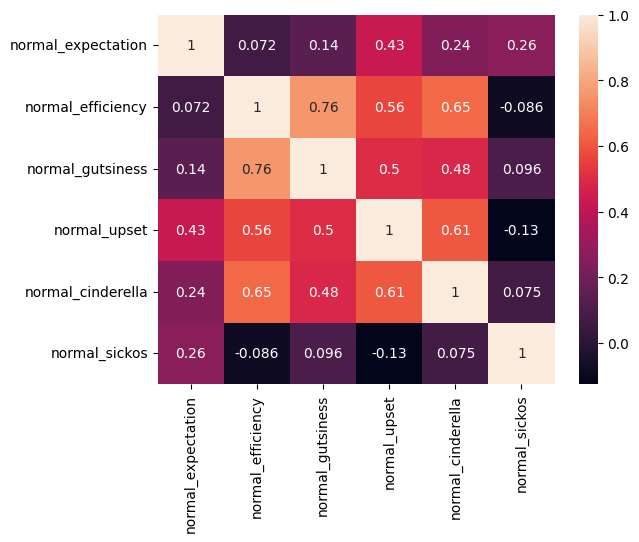

In [14]:
# correlation matrix

c_df = normal_stats_table.iloc[:, 1:]
c = c_df.columns.values
clen = len(c)

stat_corr = pd.DataFrame(np.zeros([clen, clen]), index=c, columns=c)

for i, ci in enumerate(c):
    for j, cj in enumerate(c):
        stat_corr.iloc[i, j] = c_df.iloc[:, i].corr(c_df.iloc[:, j])

display(stat_corr)

import seaborn as sns

sns.heatmap(stat_corr, annot=True)

In [15]:
# PONGKEMON !!!

sse_columns = ['HP', 'ATK','DEF','SPA','SPD','SPE']
header_stats = ['HP', 'ATK','DEF','SPA','SPD','SPE','BST']

pokemon_bst = pd.read_csv('data/pokemon_bst.csv')
pokemon_bst.columns = ['num', 'pokemon'] + header_stats + ['AVG']

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pokemon_bst)

,num,pokemon,HP,ATK,DEF,SPA,SPD,SPE,BST,AVG
0,1,Bulbasaur,45,49,49,65,65,45,318,53.00
1,2,Ivysaur,60,62,63,80,80,60,405,67.50
2,3,Venusaur,80,82,83,100,100,80,525,87.50
3,3,Venusaur (Mega Venusaur),80,100,123,122,120,80,625,104.17
4,4,Charmander,39,52,43,60,50,65,309,51.50
5,5,Charmeleon,58,64,58,80,65,80,405,67.50
6,6,Charizard,78,84,78,109,85,100,534,89.00
7,6,Charizard (Mega Charizard X),78,130,111,130,85,100,634,105.67
8,6,Charizard (Mega Charizard Y),78,104,78,159,115,100,634,105.67
9,7,Squirtle,44,48,65,50,64,43,314,52.33


In [16]:
player_pokemon_dict = dict()

pongkemon_table = stats_table.copy()
pongkemon_table.columns = ['player'] + header_stats

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pongkemon_table)

# assigning sums of squared errors for every player and pokemon
for (i, row_player) in pongkemon_table.iterrows():
    
    this_player_all_poke = np.zeros(shape=(pokemon_bst.shape[0], pokemon_bst.shape[1] - 3))
    for (j, row_poke) in pokemon_bst.iterrows():

        diff = - row_player[sse_columns] + row_poke[sse_columns]
        diff['sse'] = ((diff).apply(np.square).sum())
        this_player_all_poke[j] = np.array(diff)

    pp_df = pd.DataFrame(this_player_all_poke, columns=["D_"+x for x in sse_columns] + ['SSE']).astype(int)
    pp_df['pokemon'] = pokemon_bst['pokemon']
    pp_df.index.name = f"{row_player.player} vs. Pokemon SSE"
    pp_df = pp_df.reindex(columns=['pokemon'] + ['D_'+x for x in sse_columns] + ['SSE'])
    player_pokemon_dict.update({row_player.player: pp_df})
    display(pp_df.sort_values('SSE', ascending=True))
# 

,player,HP,ATK,DEF,SPA,SPD,SPE,BST
Stats Table,,,,,,,,
0,Kristian Banlaoi,40.0,111.0,60.0,60.0,103.0,88.0,462.0
1,Kevin Cooper,72.0,113.0,115.0,70.0,101.0,97.0,568.0
2,Rohan Chowla,81.0,114.0,105.0,112.0,104.0,65.0,581.0
3,Rose Roché,62.0,104.0,90.0,60.0,85.0,102.0,503.0
4,Aaron Carter,75.0,114.0,114.0,106.0,95.0,78.0,582.0
5,Roman Ramirez,78.0,117.0,120.0,105.0,104.0,63.0,587.0
6,Coby Lovelace,86.0,110.0,97.0,107.0,106.0,97.0,603.0
7,Paul Bartenfeld,90.0,84.0,60.0,66.0,77.0,120.0,497.0
8,Jason Jackson,82.0,107.0,97.0,94.0,90.0,106.0,576.0


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Kristian Banlaoi vs. Pokemon SSE,,,,,,,,
143,Hitmonlee,10,9,-7,-25,7,-1,905
923,Mimikyu,15,-21,20,-10,2,8,1234
572,Gallade,28,14,5,5,12,-8,1238
144,Hitmonchan,10,-6,19,-25,7,-12,1315
31,Arbok,20,-16,9,5,-24,-8,1402
...,...,...,...,...,...,...,...,...
944,Guzzlord,183,-10,-7,37,-50,-45,39532
151,Chansey,210,-106,-55,-25,2,-38,60434
305,Blissey,215,-101,-50,15,32,-33,61264


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Kevin Cooper vs. Pokemon SSE,,,,,,,,
718,Klinklang,-12,-13,0,0,-16,-7,618
932,Tapu Bulu,-2,17,0,15,-6,-22,1038
929,Kommo-o,3,-3,10,30,4,-12,1178
213,Feraligatr,13,-8,-15,9,-18,-19,1224
548,Drapion,-2,-23,-5,-10,-26,-2,1338
...,...,...,...,...,...,...,...,...
475,Deoxys (Attack Forme),-22,67,-95,110,-81,53,35468
272,Shuckle,-52,-103,115,-60,129,-92,55243
305,Blissey,183,-103,-105,5,34,-42,58068


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Rohan Chowla vs. Pokemon SSE,,,,,,,,
412,Altaria (Mega Altaria),-6,-4,5,-2,1,15,307
584,Mesprit,-1,-9,0,-7,1,15,357
942,Celesteela,16,-13,-2,-5,-3,-4,479
861,Volcanion,-1,-4,15,18,-14,5,787
949,Magearna,-1,-19,10,18,11,0,907
...,...,...,...,...,...,...,...,...
534,Happiny,19,-109,-100,-97,-39,-35,34397
305,Blissey,174,-104,-95,-37,31,-10,52547
151,Chansey,169,-109,-100,-77,1,-15,56597


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Rose Roché vs. Pokemon SSE,,,,,,,,
163,Scyther,8,6,-10,-5,-5,3,259
654,Scolipede,-2,-4,-1,-5,-16,10,402
382,Medicham (Mega Medicham),-2,-4,-5,20,0,-2,449
1120,Bombirdier,8,-1,-5,0,0,-20,490
651,Leavanny,13,-1,-10,10,-5,-10,495
...,...,...,...,...,...,...,...,...
944,Guzzlord,161,-3,-37,37,-32,-59,33173
151,Chansey,188,-99,-85,-25,20,-52,56099
305,Blissey,193,-94,-80,15,50,-47,57419


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Aaron Carter vs. Pokemon SSE,,,,,,,,
412,Altaria (Mega Altaria),0,-4,-4,4,10,2,152
584,Mesprit,5,-9,-9,-1,10,2,292
929,Kommo-o,0,-4,11,-6,10,7,322
932,Tapu Bulu,-5,16,1,-21,0,-3,732
861,Volcanion,5,-4,6,24,-5,-8,742
...,...,...,...,...,...,...,...,...
534,Happiny,25,-109,-109,-91,-30,-48,35872
305,Blissey,180,-104,-104,-31,40,-23,57122
272,Shuckle,-55,-104,116,-96,135,-73,60067


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Roman Ramirez vs. Pokemon SSE,,,,,,,,
412,Altaria (Mega Altaria),-3,-7,-10,5,1,17,473
929,Kommo-o,-3,-7,5,-5,1,22,593
584,Mesprit,2,-12,-15,0,1,17,663
458,Metagross,2,18,10,-10,-14,7,773
932,Tapu Bulu,-8,13,-5,-20,-9,12,883
...,...,...,...,...,...,...,...,...
534,Happiny,22,-112,-115,-90,-39,-33,36963
272,Shuckle,-58,-107,110,-95,126,-58,55178
305,Blissey,177,-107,-110,-30,31,-8,56803


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Coby Lovelace vs. Pokemon SSE,,,,,,,,
601,Victini,14,-10,3,-7,-6,3,399
598,Shaymin (Land Forme),14,-10,3,-7,-6,3,399
596,Manaphy,14,-10,3,-7,-6,3,399
473,Jirachi,14,-10,3,-7,-6,3,399
203,Mew,14,-10,3,-7,-6,3,399
...,...,...,...,...,...,...,...,...
534,Happiny,14,-105,-92,-92,-41,-67,34319
305,Blissey,169,-100,-87,-32,29,-42,49759
151,Chansey,164,-105,-92,-72,-1,-47,53779


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Paul Bartenfeld vs. Pokemon SSE,,,,,,,,
789,Talonflame,-12,-3,11,8,-8,6,438
1083,Maushold,-16,-9,10,-1,-2,-9,523
222,Crobat,-5,6,20,4,3,10,586
690,Cinccino,-15,11,0,-1,-17,-5,661
828,Hawlucha,-12,8,15,8,-14,-2,697
...,...,...,...,...,...,...,...,...
265,Steelix (Mega Steelix),-15,41,170,-11,18,-90,39351
151,Chansey,160,-79,-55,-31,28,-70,41511
305,Blissey,165,-74,-50,9,58,-65,42871


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Jason Jackson vs. Pokemon SSE,,,,,,,,
917,Silvally,13,-12,-2,1,5,-11,464
601,Victini,18,-7,3,6,10,-6,554
194,Zapdos (Galarian Zapdos),8,18,-7,-9,0,-6,554
473,Jirachi,18,-7,3,6,10,-6,554
598,Shaymin (Land Forme),18,-7,3,6,10,-6,554
...,...,...,...,...,...,...,...,...
534,Happiny,18,-102,-92,-79,-25,-76,31834
305,Blissey,173,-97,-87,-19,45,-51,51894
151,Chansey,168,-102,-92,-59,15,-56,53934


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Jack Massingill vs. Pokemon SSE,,,,,,,,
774,Genesect,-11,12,-6,8,-11,-4,502
601,Victini,18,-8,-1,-12,-6,-3,578
203,Mew,18,-8,-1,-12,-6,-3,578
315,Celebi,18,-8,-1,-12,-6,-3,578
473,Jirachi,18,-8,-1,-12,-6,-3,578
...,...,...,...,...,...,...,...,...
534,Happiny,18,-103,-96,-97,-41,-73,36568
305,Blissey,173,-98,-91,-37,29,-48,52328
151,Chansey,168,-103,-96,-77,-1,-53,56788


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Evan Sooklal vs. Pokemon SSE,,,,,,,,
158,Seaking,-6,3,5,-3,-2,-16,339
55,Golbat,-11,-9,10,-3,-7,6,396
703,Sawsbuck,-6,11,10,-8,-12,11,586
802,Furfrou,-11,-9,0,-3,8,18,599
442,Glalie,-6,-9,20,12,-2,-4,681
...,...,...,...,...,...,...,...,...
265,Steelix (Mega Steelix),-11,36,170,-13,13,-54,33571
151,Chansey,164,-84,-55,-33,23,-34,39751
305,Blissey,169,-79,-50,7,53,-29,41001


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Leah Baetcke vs. Pokemon SSE,,,,,,,,
306,Raikou,0,-19,5,-5,-3,10,520
465,Latios,-10,-14,10,10,7,5,570
193,Zapdos,0,-14,15,5,-13,-5,640
754,Hydreigon,2,1,20,5,-13,-7,648
192,Articuno (Galarian Articuno),0,-19,15,5,-3,-10,720
...,...,...,...,...,...,...,...,...
265,Steelix (Mega Steelix),-15,21,160,-65,-8,-75,36180
305,Blissey,165,-94,-60,-45,32,-50,45210
151,Chansey,160,-99,-65,-85,2,-55,49880


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Gabe Silverstein vs. Pokemon SSE,,,,,,,,
754,Hydreigon,8,-2,-14,6,-9,-11,502
774,Genesect,-13,13,-9,1,-4,-10,536
315,Celebi,16,-7,-4,-19,1,-9,764
598,Shaymin (Land Forme),16,-7,-4,-19,1,-9,764
601,Victini,16,-7,-4,-19,1,-9,764
...,...,...,...,...,...,...,...,...
534,Happiny,16,-102,-99,-104,-34,-79,38674
305,Blissey,171,-97,-94,-44,36,-54,53634
151,Chansey,166,-102,-99,-84,6,-59,58334


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Reagan Fryatt vs. Pokemon SSE,,,,,,,,
596,Manaphy,15,-3,-9,15,2,-11,665
601,Victini,15,-3,-9,15,2,-11,665
315,Celebi,15,-3,-9,15,2,-11,665
203,Mew,15,-3,-9,15,2,-11,665
598,Shaymin (Land Forme),15,-3,-9,15,2,-11,665
...,...,...,...,...,...,...,...,...
534,Happiny,15,-98,-104,-70,-33,-81,33195
305,Blissey,170,-93,-99,-10,37,-56,51955
151,Chansey,165,-98,-104,-50,7,-61,53915


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Carla Betancourt vs. Pokemon SSE,,,,,,,,
596,Manaphy,1,-4,3,-5,-20,-20,851
203,Mew,1,-4,3,-5,-20,-20,851
315,Celebi,1,-4,3,-5,-20,-20,851
601,Victini,1,-4,3,-5,-20,-20,851
598,Shaymin (Land Forme),1,-4,3,-5,-20,-20,851
...,...,...,...,...,...,...,...,...
889,Wishiwashi (Solo Form),-54,-84,-77,-80,-95,-80,37726
305,Blissey,156,-94,-87,-30,15,-65,46091
151,Chansey,151,-99,-92,-70,-15,-70,51091


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Kevin Lee vs. Pokemon SSE,,,,,,,,
1062,Enamorus (Therian Forme),-7,-5,1,15,-6,6,372
557,Abomasnow (Mega Abomasnow),9,12,-4,12,-1,-10,486
400,Camerupt (Mega Camerupt),-11,0,-9,25,-1,-20,1228
942,Celesteela,16,-19,-6,-13,-5,21,1288
949,Magearna,-1,-25,6,10,9,25,1468
...,...,...,...,...,...,...,...,...
427,Feebas,-61,-105,-89,-110,-51,40,38968
305,Blissey,174,-110,-99,-45,29,15,55268
272,Shuckle,-61,-110,121,-110,124,-35,59163


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Cason Duszak vs. Pokemon SSE,,,,,,,,
194,Zapdos (Galarian Zapdos),5,16,-7,4,-11,-3,476
917,Silvally,10,-14,-2,14,-6,-8,596
203,Mew,15,-9,3,19,-1,-3,686
598,Shaymin (Land Forme),15,-9,3,19,-1,-3,686
596,Manaphy,15,-9,3,19,-1,-3,686
...,...,...,...,...,...,...,...,...
475,Deoxys (Attack Forme),-35,71,-77,99,-81,47,30766
305,Blissey,170,-99,-87,-6,34,-48,49766
151,Chansey,165,-104,-92,-46,4,-53,51446


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Will Simpson vs. Pokemon SSE,,,,,,,,
315,Celebi,12,-9,-6,-5,-6,-3,331
601,Victini,12,-9,-6,-5,-6,-3,331
598,Shaymin (Land Forme),12,-9,-6,-5,-6,-3,331
596,Manaphy,12,-9,-6,-5,-6,-3,331
473,Jirachi,12,-9,-6,-5,-6,-3,331
...,...,...,...,...,...,...,...,...
534,Happiny,12,-104,-101,-90,-41,-73,36271
305,Blissey,167,-99,-96,-30,29,-48,50951
151,Chansey,162,-104,-101,-70,-1,-53,54971


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Ann Hall vs. Pokemon SSE,,,,,,,,
596,Manaphy,6,-8,-8,-3,14,3,378
203,Mew,6,-8,-8,-3,14,3,378
598,Shaymin (Land Forme),6,-8,-8,-3,14,3,378
601,Victini,6,-8,-8,-3,14,3,378
473,Jirachi,6,-8,-8,-3,14,3,378
...,...,...,...,...,...,...,...,...
534,Happiny,6,-103,-103,-88,-21,-67,33928
305,Blissey,161,-98,-98,-28,49,-42,50078
151,Chansey,156,-103,-103,-68,19,-47,52748


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Helen Dunn vs. Pokemon SSE,,,,,,,,
1010,Obstagoon,8,-4,4,-8,-9,-10,341
604,Serperior,-10,-19,-2,7,5,8,603
407,Flygon,-5,6,-17,12,-10,-5,619
980,Dubwool,-13,-14,3,-8,0,-17,727
651,Leavanny,-10,9,-17,2,-10,-13,743
...,...,...,...,...,...,...,...,...
475,Deoxys (Attack Forme),-35,86,-77,112,-70,45,34019
151,Chansey,165,-89,-92,-33,15,-55,47949
305,Blissey,170,-84,-87,7,45,-50,48099


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Noah Dale vs. Pokemon SSE,,,,,,,,
407,Flygon,-15,4,1,12,-15,1,612
1117,Tinkaton,-10,-21,-2,2,10,-5,674
651,Leavanny,-20,7,1,2,-15,-7,728
42,Nidoqueen,-5,-4,8,7,-10,-23,783
1010,Obstagoon,-2,-6,22,-8,-14,-4,800
...,...,...,...,...,...,...,...,...
475,Deoxys (Attack Forme),-45,84,-59,112,-75,51,33332
305,Blissey,160,-86,-69,7,40,-44,41342
151,Chansey,155,-91,-74,-33,10,-49,41372


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Yvonne Nguyen vs. Pokemon SSE,,,,,,,,
1046,Zarude,5,14,1,-5,2,-6,287
854,Zygarde (50% Forme),8,-6,17,6,2,-16,685
154,Kangaskhan (Mega Kangaskhan),5,19,-4,-15,7,-11,797
758,Terrakion,-9,23,-14,-3,-3,-3,833
315,Celebi,0,-6,-4,25,7,-11,847
...,...,...,...,...,...,...,...,...
475,Deoxys (Attack Forme),-50,74,-84,105,-73,39,32907
305,Blissey,155,-96,-94,0,42,-56,46977
151,Chansey,150,-101,-99,-40,12,-61,47967


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Anna Brown vs. Pokemon SSE,,,,,,,,
407,Flygon,3,-2,-17,4,-13,3,496
651,Leavanny,-2,1,-17,-6,-13,-5,524
382,Medicham (Mega Medicham),-17,-2,-12,4,-8,3,526
213,Feraligatr,8,3,3,3,-10,-19,552
293,Kingdra,-2,-7,-2,19,2,-12,566
...,...,...,...,...,...,...,...,...
475,Deoxys (Attack Forme),-27,78,-77,104,-73,53,31696
305,Blissey,178,-92,-87,-1,42,-42,51246
151,Chansey,173,-97,-92,-41,12,-47,51836


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Brian Tafazoli vs. Pokemon SSE,,,,,,,,
158,Seaking,0,8,5,-3,-6,-7,183
179,Eevee (Partner Eevee),-15,-9,10,-3,-1,0,416
55,Golbat,-5,-4,10,-3,-11,15,496
993,Cramorant,-10,1,-5,17,9,10,596
595,Phione,0,-4,20,12,-6,5,621
...,...,...,...,...,...,...,...,...
475,Deoxys (Attack Forme),-30,96,-40,112,-66,75,34241
151,Chansey,170,-79,-55,-33,19,-25,40241
305,Blissey,175,-74,-50,7,49,-20,41451


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Sam Tellis vs. Pokemon SSE,,,,,,,,
603,Servine,0,0,15,0,0,-7,274
381,Medicham,0,0,15,0,0,-10,325
1116,Tinkatuff,5,-5,-5,-15,7,-12,493
371,Delcatty,10,5,5,-5,-20,0,575
1064,Floragato,1,20,3,0,-12,-7,603
...,...,...,...,...,...,...,...,...
265,Steelix (Mega Steelix),15,65,170,-5,20,-60,37375
151,Chansey,190,-55,-55,-25,30,-40,45275
305,Blissey,195,-50,-50,15,60,-35,48075


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Nathan Snow vs. Pokemon SSE,,,,,,,,
473,Jirachi,14,-12,-6,15,-4,0,617
596,Manaphy,14,-12,-6,15,-4,0,617
315,Celebi,14,-12,-6,15,-4,0,617
598,Shaymin (Land Forme),14,-12,-6,15,-4,0,617
203,Mew,14,-12,-6,15,-4,0,617
...,...,...,...,...,...,...,...,...
534,Happiny,14,-107,-101,-70,-39,-70,33167
305,Blissey,169,-102,-96,-10,31,-45,51267
151,Chansey,164,-107,-101,-50,1,-50,53547


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Piper Parker vs. Pokemon SSE,,,,,,,,
802,Furfrou,-10,-13,0,2,-12,0,417
1117,Tinkaton,0,-18,17,7,3,-8,735
50,Ninetales,-12,-17,15,18,-2,-2,990
993,Cramorant,-15,-8,-5,22,-7,-17,1136
1107,Toedscruel,-5,-23,5,17,18,-2,1196
...,...,...,...,...,...,...,...,...
265,Steelix (Mega Steelix),-10,32,170,-8,-7,-72,35321
151,Chansey,165,-88,-55,-28,3,-52,41491
305,Blissey,170,-83,-50,12,33,-47,41731


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Matthew Rusten vs. Pokemon SSE,,,,,,,,
222,Crobat,-2,-9,-17,-1,-7,11,545
407,Flygon,-7,1,-17,9,-7,-19,830
604,Serperior,-12,-24,-2,4,8,-6,840
1010,Obstagoon,6,-9,4,-11,-6,-24,866
963,Cinderace,-7,17,-22,-6,-12,0,1002
...,...,...,...,...,...,...,...,...
475,Deoxys (Attack Forme),-37,81,-77,109,-67,31,31190
305,Blissey,168,-89,-87,4,48,-64,50130
151,Chansey,163,-94,-92,-36,18,-69,50250


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Cassie Deering vs. Pokemon SSE,,,,,,,,
55,Golbat,4,5,10,5,1,9,248
1064,Floragato,-10,5,3,0,-11,2,259
179,Eevee (Partner Eevee),-6,0,10,5,11,-6,318
613,Watchog,-11,10,9,0,-5,-4,343
951,Poipole,-4,-2,7,13,-7,-8,351
...,...,...,...,...,...,...,...,...
475,Deoxys (Attack Forme),-21,105,-40,120,-54,69,35143
151,Chansey,179,-70,-55,-25,31,-31,42513
305,Blissey,184,-65,-50,15,61,-26,45203


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Yafu LastName vs. Pokemon SSE,,,,,,,,
158,Seaking,0,-6,5,5,-9,2,171
838,Trevenant,5,12,16,5,-7,-10,599
684,Garbodor,0,-3,22,0,-7,9,623
753,Zweilous,-8,-13,10,5,-19,-8,783
920,Komala,-15,17,5,15,6,-1,801
...,...,...,...,...,...,...,...,...
475,Deoxys (Attack Forme),-30,82,-40,120,-69,84,35441
151,Chansey,170,-93,-55,-25,16,-16,41711
305,Blissey,175,-88,-50,15,46,-11,43331


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Alex LastName vs. Pokemon SSE,,,,,,,,
654,Scolipede,2,2,-8,-8,-10,12,380
548,Drapion,12,-8,13,-3,-4,-5,427
382,Medicham (Mega Medicham),2,2,-12,17,6,0,477
718,Klinklang,2,2,18,7,6,-10,517
163,Scyther,12,12,-17,-8,1,5,667
...,...,...,...,...,...,...,...,...
944,Guzzlord,165,3,-44,34,-26,-57,34251
151,Chansey,192,-93,-92,-28,26,-50,57937
305,Blissey,197,-88,-87,12,56,-45,59427


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Luci Nguyen vs. Pokemon SSE,,,,,,,,
718,Klinklang,-15,-4,0,1,-17,-21,972
548,Drapion,-5,-14,-5,-9,-27,-16,1312
604,Serperior,0,-29,-20,6,-7,2,1330
1046,Zarude,30,16,-10,1,-7,-6,1342
1149,Iron Treads,15,8,5,3,-32,-5,1372
...,...,...,...,...,...,...,...,...
475,Deoxys (Attack Forme),-25,76,-95,111,-82,39,35992
272,Shuckle,-55,-94,115,-59,128,-106,56187
305,Blissey,180,-94,-105,6,33,-56,56522


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Eric LastName vs. Pokemon SSE,,,,,,,,
718,Klinklang,-2,-13,0,-1,-21,-16,871
929,Kommo-o,13,-3,10,29,-1,-21,1561
382,Medicham (Mega Medicham),-2,-13,-30,9,-21,-6,1631
932,Tapu Bulu,8,17,0,14,-11,-31,1631
548,Drapion,8,-23,-5,-11,-31,-11,1821
...,...,...,...,...,...,...,...,...
944,Guzzlord,161,-12,-62,26,-53,-63,37363
272,Shuckle,-42,-103,115,-61,124,-101,54896
305,Blissey,193,-103,-105,4,29,-51,62341


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Kim LastName vs. Pokemon SSE,,,,,,,,
179,Eevee (Partner Eevee),-9,0,10,5,4,-6,258
55,Golbat,1,5,10,5,-6,9,268
429,Castform,-4,-5,10,10,-11,-11,483
388,Volbeat,-9,-2,15,-13,4,4,511
553,Lumineon,-5,-6,16,9,5,10,523
...,...,...,...,...,...,...,...,...
475,Deoxys (Attack Forme),-24,105,-40,120,-61,69,36083
151,Chansey,176,-70,-55,-25,24,-31,41063
305,Blissey,181,-65,-50,15,54,-26,43303


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Julie Jackson vs. Pokemon SSE,,,,,,,,
1120,Bombirdier,-1,-8,-12,-9,4,-6,342
651,Leavanny,4,-8,-17,1,-1,4,387
187,Kabutops,-11,4,8,-4,-11,-8,402
1101,Mabosstiff,9,9,-7,-9,-11,-3,422
213,Feraligatr,14,-6,3,10,2,-10,445
...,...,...,...,...,...,...,...,...
475,Deoxys (Attack Forme),-21,69,-77,111,-61,62,31017
151,Chansey,179,-106,-92,-34,24,-38,54917
305,Blissey,184,-101,-87,6,54,-33,55667


,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
Carolyn LastName vs. Pokemon SSE,,,,,,,,
1120,Bombirdier,-1,-8,-12,-9,4,-6,342
651,Leavanny,4,-8,-17,1,-1,4,387
187,Kabutops,-11,4,8,-4,-11,-8,402
1101,Mabosstiff,9,9,-7,-9,-11,-3,422
213,Feraligatr,14,-6,3,10,2,-10,445
...,...,...,...,...,...,...,...,...
475,Deoxys (Attack Forme),-21,69,-77,111,-61,62,31017
151,Chansey,179,-106,-92,-34,24,-38,54917
305,Blissey,184,-101,-87,6,54,-33,55667


In [17]:
best_pokemon_table = pd.DataFrame(columns=player_pokemon_dict['Roman Ramirez'].columns)
best_pokemon_table.index.name = "Best Pokemon Match"

for (i, row) in pongkemon_table.iterrows(): 
    best_pokemon_table.loc[i] = player_pokemon_dict[row.player].sort_values('SSE', ascending=True).reset_index(drop=True).iloc[0]
# display(pongkemon_table)
# display(best_pokemon_table)

total_pokemon_table = pd.concat([pongkemon_table, best_pokemon_table], axis=1).reset_index(drop=True)
sum_sse = total_pokemon_table.SSE.sum()
display(total_pokemon_table.sort_values('SSE', ascending=True))
display(sum_sse)

# 40-120's SSE: 17238
# 60-120's SSE: 15360

,player,HP,ATK,DEF,SPA,SPD,SPE,BST,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
4,Aaron Carter,75.0,114.0,114.0,106.0,95.0,78.0,582.0,Altaria (Mega Altaria),0,-4,-4,4,10,2,152
29,Yafu LastName,80.0,98.0,60.0,60.0,89.0,66.0,453.0,Seaking,0,-6,5,5,-9,2,171
23,Brian Tafazoli,80.0,84.0,60.0,68.0,86.0,75.0,453.0,Seaking,0,8,5,-3,-6,-7,183
28,Cassie Deering,71.0,75.0,60.0,60.0,74.0,81.0,421.0,Golbat,4,5,10,5,1,9,248
33,Kim LastName,74.0,75.0,60.0,60.0,81.0,81.0,431.0,Eevee (Partner Eevee),-9,0,10,5,4,-6,258
3,Rose Roché,62.0,104.0,90.0,60.0,85.0,102.0,503.0,Scyther,8,6,-10,-5,-5,3,259
24,Sam Tellis,60.0,60.0,60.0,60.0,75.0,90.0,405.0,Servine,0,0,15,0,0,-7,274
21,Yvonne Nguyen,100.0,106.0,104.0,75.0,93.0,111.0,589.0,Zarude,5,14,1,-5,2,-6,287
2,Rohan Chowla,81.0,114.0,105.0,112.0,104.0,65.0,581.0,Altaria (Mega Altaria),-6,-4,5,-2,1,15,307
17,Will Simpson,88.0,109.0,106.0,105.0,106.0,103.0,617.0,Celebi,12,-9,-6,-5,-6,-3,331


16307

In [18]:
best_pokemon_table['D_HP'].mean()

best_pokemon_table.iloc[:,1:].mean()

D_HP       0.444444
D_ATK     -2.861111
D_DEF     -1.972222
D_SPA      0.305556
D_SPD         -4.75
D_SPE     -1.916667
SSE      452.972222
dtype: object

In [19]:
### matches tables
# matches_1s
# matches_2s
# matches_table

### players tables
# players
# cups_table
# wl_table
# fa_table, remove: GP
# hcs_table
# str_table, remove: PTS, expectation, cinderella
# sickos_table, remove: +/-, W_PCT, sickos, guisiness
# upset_table, remove: total_upset
# raw_stats_table
# stats_table
# best_pokemon_table: remove: HP, ATK, DEF, SPA, SPD, SPE, BST

In [20]:
# export matches table
export(matches_table, 'matches_table')

In [21]:
# player pokemon table matches
# export whole dictionary
for (key, value) in player_pokemon_dict.items():
    export(value, f"player_pokemon_sse/pkmn_sse_{key.replace(' ', '_')}")

In [22]:
# merge
list_players_tables = list()
list_players_tables.append(players.iloc[:,[x not in [''] for x in players.columns]])
# list_players_tables.append(cups_table.iloc[:,[x not in ['player'] for x in cups_table.columns]])
list_players_tables.append(wl_table.iloc[:,[x not in ['player'] for x in wl_table.columns]])
list_players_tables.append(fa_table.iloc[:,[x not in ['player', 'GP'] for x in fa_table.columns]])
list_players_tables.append(hcs_table.iloc[:,[x not in ['player'] for x in hcs_table.columns]])
list_players_tables.append(str_table.iloc[:,[x not in ['player', 'PTS', 'expectation', 'cinderella'] for x in str_table.columns]])
list_players_tables.append(sickos_table.iloc[:,[x not in ['player', '+/-', 'W_PCT', 'sickos', 'gutsiness'] for x in sickos_table.columns]])
list_players_tables.append(upset_table.iloc[:,[x not in ['player'] for x in upset_table.columns]])
list_players_tables.append(raw_stats_table.iloc[:,[x not in ['player'] for x in raw_stats_table.columns]])
list_players_tables.append(normal_stats_table.iloc[:,[x not in ['player'] for x in normal_stats_table.columns]])
list_players_tables.append(stats_table.iloc[:,[x not in ['player'] for x in stats_table.columns]])
list_players_tables.append(best_pokemon_table.iloc[:,[x not in ['player', 'HP', 'ATK', 'DEF', 'SPA', 'SPD', 'SPE', 'BST'] for x in best_pokemon_table.columns]])

players_table =  pd.concat(list_players_tables, join='outer', axis=1).fillna(np.NaN)
players_table = players_table.sort_values('player', ascending=True).reset_index(drop=True)

# df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['DATE'], how='outer'), data_frames)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(players_table)

# export players table
export(players_table, 'players_table', index=False)

,player,grad_year,2019,2020,2021,2022,2023,seed_2021_2s,seed_2022_1s,seed_2022_2s,seed_2023_1s,beach_week_2023,seed_2023_2s,num_events,z_seed_2021_2,z_seed_2022_1,z_seed_2022_2,z_seed_2023_1,z_seed_2023_2,avg_norm_seed,W_1s,UW_1s,EW_1s,L_1s,UL_1s,EL_1s,RL_1s,URL_1s,ERL_1s,W_2s,UW_2s,EW_2s,L_2s,UL_2s,EL_2s,RL_2s,URL_2s,ERL_2s,UW,EW,UL,EL,URL,ERL,GP,UGP,EGP,ODW,ODL,ODRL,UDW,UDL,UDRL,W,L,RL,PTS,PTS/EV,W_PCT,UW_PCT,EW_PCT,GP_1s,PF_1s,PA_1s,CA_1s,+/-_1s,GP_2s,PF_2s,PA_2s,CA_2s,+/-_2s,PF,PA,CA,+/-,PF/G,PA/G,CA/G,+/-/G,PF/PA,PF/CA,(+/-)/CA,hcs_1s,hcs_2s,hcs,hcs/event,total_seeds_1s,total_seeds_2s,total_seeds,avg_norm_total_seeds_1s,avg_norm_total_seeds_2s,SOV_1s,SOV_2s,SOS,SOV,z_SOS,z_SOV,z_PTS,z_PTS/EV,avg_norm_seed,PTS/EV,n_avg_norm_seed,n_PTS/EV,z_+/-,z_W_PCT,sickos_resids,EW,EL,EGP,raw_poll_scores,GP,W,total_upset,avg_upset,total_upset/GP,total_upset/W,raw_expectation,raw_efficiency,raw_gutsiness,raw_upset,raw_cinderella,raw_sickos,normal_expectation,normal_efficiency,normal_gutsiness,normal_upset,normal_cinderella,normal_sickos,expectation,efficiency,gutsiness,upset,cinderella,sickos,BST,pokemon,D_HP,D_ATK,D_DEF,D_SPA,D_SPD,D_SPE,SSE
0,Aaron Carter,2023,tenors,tenors,tenors,tenors,NaN,1.0,5.0,3.0,8.0,True,NaN,4,-1.479020,-0.670820,-0.752773,-0.355409,NaN,-0.814506,8,2,6,3,2,1,0,0,0,3,1,2,4,2,2,0,0,0,3,8,4,3,0,0,18,7,11,7,7,0,4,0,0,11,7,0,14,3.500000,61.111111,42.857143,72.727273,11,65,52,72,13,7,38,38,45,0,103,90,117,13,5.722222,5.000000,6.500000,0.722222,114.444444,88.034188,0.111111,13,8,21,5.250000,94,44,138,0.502674,0.785714,59.079670,20.555556,0.355806,0.398176,-1.176612,0.662378,0.879208,0.219802,-0.814506,3.500000,-0.520369,0.500000,1.420296,0.222222,-1.003010,8,3,11,4.0,18,11,3.742857,0.415873,0.207937,0.340260,-0.270369,0.111111,0.454545,3.742857,1.151425,-1.003010,0.576073,0.894737,0.888889,0.759543,0.575713,0.467629,75.0,114.0,114.0,106.0,95.0,78.0,582.0,Altaria (Mega Altaria),0,-4,-4,4,10,2,152
1,Alex LastName,idk,NaN,NaN,NaN,NaN,non-marcher,NaN,NaN,NaN,NaN,False,4.0,1,NaN,NaN,NaN,NaN,-0.211289,-0.211289,0,0,0,0,0,0,0,0,0,1,0,1,2,1,1,0,0,0,0,1,1,1,0,0,3,1,2,1,1,0,0,1,0,1,2,0,1,1.000000,33.333333,0.000000,50.000000,0,0,0,0,0,3,14,17,18,-3,14,17,18,-3,4.666667,5.666667,6.000000,-1.000000,82.352941,77.777778,-0.166667,0,3,3,3.000000,0,16,16,NaN,0.666667,NaN,10.000000,0.333333,0.100000,-1.386777,-0.954314,-0.753607,-0.753607,-0.211289,1.000000,-0.134987,0.142857,-0.327761,-0.333333,0.266859,1,1,2,NaN,3,1,0.166667,0.083333,0.055556,0.166667,-0.992130,-0.166667,0.000000,0.166667,0.623656,0.266859,0.288115,0.631579,0.611111,0.033822,0.311828,0.738397,58.0,98.0,97.0,63.0,79.0,100.0,495.0,Scolipede,2,2,-8,-8,-10,12,380
2,Ann Hall,2023,snare,snare,snare,snare,NaN,7.0,NaN,7.0,16.0,True,NaN,3,1.056443,NaN,0.752773,1.066228,NaN,0.958481,3,0,3,2,1,1,0,0,0,1,0,1,3,2,1,1,0,1,0,4,3,2,0,1,10,3,7,0,2,0,4,3,1,4,5,1,5,1.666667,40.000000,0.000000,57.142857,5,26,21,30,5,5,26,31,33,-5,52,52,63,0,5.200000,5.200000,6.300000,0.000000,100.000000,82.539683,0.000000,5,6,11,3.666667,73,15,88,0.858824,0.375000,20.952381,16.666667,0.383088,0.188095,-0.921467,-0.476668,-0.251202,-0.083734,0.958481,1.666667,0.612351,0.238095,0.000000,-0.200000,0.106620,4,2,7,7.0,10,4,3.468254,0.385362,0.346825,0.867063,0.517113,0.000000,0.285714,3.468254,0.838694,0.106620,0.890251,0.789474,0.785714,0.703817,0.419347,0.704230,94.0,108.0,108.0,103.0,86.0,97.0,596.0,Manaphy,6,-8,-8,-3,14,3,378
3,Anna Brown,2022,cymbals,cymbals,cymbals,NaN,NaN,7.0,NaN,NaN,NaN,False,NaN,1,1.056443,NaN,NaN,NaN,NaN,1.056443,0,0,0,0,0,0,0,0,0,1,0,1,2,1,1,0,0,0,0,1,1,1,0,0,3,1,2,0,0,0,1,2,0,1,2,0,1,1.000000,33.333333,0.000000,50.000000,0,0,0,0,0,3,14,16,18,-2,14,16,18,-2,4.666667,5.333333,6.000000,-0.666667,87.500000,77.777778,-0.111111,0,3,3,3.000000,0,10,10,NaN,0.416667,NaN,16.666667,0.583333,0.166667,0.951234,-0.592852,-0.753607,-0.753607,1.056443,1.000000,0.674937,0.142857,-0.218507,-0.333333,0.098812,1,1,2,0.0,3,1,1.238095,0.309524,0.412698,1.238095,-0.182206,-0.111111,0.000000,1.238095,1